In [ ]:
# Import Libraries
import csv
import gensim
import imblearn
import keras
import matplotlib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import random
import re
import sklearn
import snscrape.modules.twitter as sntwitter
import string
import tensorflow as tf
import tweepy
import unicodedata

from authpy import authpy
from collections import Counter
from contractions import CONTRACTION_MAP 

from csv import reader
from csv import writer

from datasets import load_dataset, Features, ClassLabel, Value
from feature_extractors import bow_extractor, tfidf_extractor,tfidf_transformer, averaged_word_vectorizer, tfidf_weighted_averaged_word_vectorizer
from goose3 import Goose
from html.parser import HTMLParser

from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

from IPython.display import display

from itertools import repeat

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.layers import Input
from keras.layers.core import Activation, Dropout, Dense
from keras.losses import binary_crossentropy
from keras.models import Model
from keras.models import Sequential
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from nltk.stem import WordNetLemmatizer

from normalization import normalize_corpus

from numpy import argmax
from numpy import array

from pprint import pprint

from sklearn import metrics
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.multiclass import unique_labels

from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Embedding

from transformers import AutoTokenizer
from transformers import create_optimizer
from transformers import DefaultDataCollator
from transformers import TFAutoModelForSequenceClassification
from transformers import TFBertModel

from urllib.request import Request, urlopen

from utils import build_feature_matrix

from wordcloud import WordCloud, STOPWORDS

### Answer (a)

(a) Using the Twitter API, collect at least 10,000 sports news items in the English language from the past year

How data was collected - 

I created the Twitter developer account and got elevated access from Twitter. When I try to fetch the tweets through Twitter API, I came across an issue where only 200 records were allowed to be fetched through it. So later, I tried to use Tweepy to fetch tweets and it also had some 2400 records restrictions. Since the requirement to fetch 10,000 records I used snscrape which can literally pull millions of records at a time.

In order to get English tweets, I got a set list of English Twitter sports news channels, for example - @SkySportsNews, @sportingnews, @Sport_EN, @btsport, @BBCSport, @cnnsport, @ICC, @Sport24news. From this list, I sorted the channels which has the highest number of tweets and which contain an external URL to extract the relevant article information.

Below shows the code on how to extract the Tweets by setting the max_tweets to 50,000, so that as a final output I can receive around ~15,000 records in the Raw Dataset. Because most of the Tweets did not have an external URL. So if I query around 50,000 records I would be able to get around 15,000 records.

In [ ]:
# Setting 50,000 records, so that we can atleast receive around 10,000 records
max_tweets = 50000

# Open the csv file given using the open function
csvFile = open('Twitter_RawData.csv', 'a', newline='', encoding="utf-8")

# Create writer object using the writer method of the csv
csvWriter = csv.writer(csvFile)

In [ ]:
# Check how many Tweets a particular Twitter account has got.For that purpose I've use the Twitter API.

# Calling the api - Store the Token information in different file
api = authpy('Twitter_Authentication.json')

In [ ]:
# Get the Number of Tweets using the list.txt, where I have mentioned all the English Sport News Channels
# Open the file and List the Sport News Channels
screen_names = [] 

with open('Sports_NewsChannels_List.txt', 'r') as targets_file:
     targets_list = targets_file.readlines()

for item in targets_list:
     screen_names.append(item.strip("\n"))
print(screen_names)
  
# Print the number of Tweets
for screen_name in screen_names:
    twitter_screen_name = api.get_user(screen_name=screen_name)
    print("The number of Tweets the " + screen_name + " has posted are : " + str(twitter_screen_name.statuses_count))

['BBCSport', 'cnnsport', 'ICC', 'Sport24news']
The number of Tweets the BBCSport has posted are : 552324
The number of Tweets the cnnsport has posted are : 35648
The number of Tweets the ICC has posted are : 105864
The number of Tweets the Sport24news has posted are : 207324


In [ ]:
# List of Sports Channel's screen_name to extract the tweets from
# Create the query
screen_names_list = ["from:" + s_name for s_name in screen_names]
screen_names_list = " OR ".join(screen_names_list) + " "

# Select the queries inbetween 2021-01-01 to 2022-01-01, english language and avoid retweeted tweets
time_query = " -is:retweet lang:en since:2021-01-01 until:2022-01-01"

# Final query
tweet_query = screen_names_list + time_query
print("Query to fetch the Tweet_text : ",tweet_query)

Query to fetch the Tweet_text :  from:BBCSport OR from:cnnsport OR from:ICC OR from:Sport24news  -is:retweet lang:en since:2021-01-01 until:2022-01-01


At this point, I have queried that the Tweet raw data should cntain Tweets only from the channels mentioned, language should be English, the Date should cover from 2021-01-01 to 2022-01-01.

In [ ]:
# Method to find the Tweets with an external article, If the tweet doesn't have an external link ignore that tweet
url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

# Find the Tweets with the External URL

#Since twitter automatically shortens its URLs, all the URLs follow the same pattern. 
#Yet sometimes certain tweets contained links as a reference to the original Tweet. 
#These links need to be removed since they do not provide any value. 
#Thereby urllib library from python was utilized to open each URL as the tweets were getting pulled,
#resolve the fully qualified domain name and check if its not equal to the twitter.com’s main apex domain. 
#Thereby only tweets containing external URLs that are not from the main twitter.com website were accepted as a valid data item. 
#Certain links were broken/ not resolving, to skip these a try/except block was utilized
def checkExternalUrl(tweet):
    urls = re.findall(url_regex, tweet)
    valid_Urls=[]
    for url in urls:
        try:
            request = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
            response = urlopen(request)
            actual_url = response.geturl()
            twitter_url = re.findall("twitter.com", actual_url)
            if not (twitter_url):
                valid_Urls.append(actual_url)
        except:
            print(url)
    return len(valid_Urls)>0

# Creating list to append tweet data to
tweets_list = []

# For loop to write the reteived records to the csv declared above
for i,tweet in enumerate(sntwitter.TwitterSearchScraper(tweet_query).get_items()):
    if i > max_tweets:
        break
    if checkExternalUrl(tweet.rawContent):
        print('Running Index :', i)
        tweets_list.append([tweet.date, tweet.id, tweet.rawContent, tweet.user.username])
        csvWriter.writerow([tweet.date, tweet.id, tweet.rawContent, tweet.user.username])

# Close the after writing all the fetched records
csvFile.close()

At this point, I have stored the Tweet Raw Data, But we cannot get the correct Sport News content through the Tweet_text, so that we need much more information about the Sport inorder to do support the Srilankan startup company. So, I have used goose3 to do the web scrapping and get the content for each article and store it in a different CSV file.

In [ ]:
# Now, using the external link in the Tweet content, pull the Content of the article using goose3
# When we extract the Tweet content, we will be able to fetch the twitter link of that particular link and the external link
# Since the last url, will be always the Twitter url, we should remove that and get the content from the rest of the url(s)
def removeTwitterUrl(urls):
    if len(urls) > 1:
        return urls[:-1]
    else:
        return urls

goose = Goose({'browser_user_agent': 'Mozilla'})    
    
# Use the external url and extract the content
with open('Twitter_RawData.csv', 'r', encoding="utf-8") as read_obj, open('Twitter_Data_withContent.csv', 'w', newline='', encoding="utf-8") as write_obj:
    
    # Read rows from the CSV
    csv_reader = reader(read_obj)
    
    # Wite rows in the CSV
    csv_writer = writer(write_obj)
    
    # Add a row to the CSV
    csv_writer.writerow(columns)
    
    # For loop to run through the raw data csv and pull the content using web scraping
    for idx, row in enumerate(csv_reader):
        print('Running row :', idx+1)
        tweet_id = row[1]
        tweet_content = row[2]
        tweet_urls = re.findall(url_regex, tweet_content)
        # If there are more than 1 urls, handle removeTwitterUrl
        contentUrls = removeTwitterUrl(tweet_urls)

        # Extract the article content using goose3
        for url in contentUrls:
            try:
                article = goose.extract(url)
                article_content = article.title + '\n' + article.cleaned_text
                csv_writer.writerow([tweet_id, tweet_urls, article_content])
            except:
                print(idx, url)
  
 # Close the write and read CSV
read_obj.close()
write_obj.close()

Explain the challenges encountered...

1- Faced issue to retrieve 10,000 tweets using the Twitter API and Tweepy. So finally I used the snscrape to retrieve records. <br>
2- Tweets with Twitter card kept on failing, because of the Media issue: https://github.com/JustAnotherArchivist/snscrape/issues/470  <br>
3- Witnessed some encoding issues, while reading and writing the CSV, so had to pass the parameter to every instance, where I used the CSV. <br>
4- Took 8 hours to pull the Raw Twitter data and 9 to 10 hours to pull the content from the article. using snscrape. If any failures happen in between, the execution stops (doesn't skip and move forward) <br>
5- Handling broken Tweeter URL.

### Answer (b)

(b) Describe the dataset collected in terms of the number of news items, the total number of words, the number of unique words and the distribution of lengths in tokens of the new items.

First let's look into the Twitter_RawData.csv dataset and it's description.

In [ ]:
# Read the Raw data collected and Breif look at the dataset collected
df = pd.read_csv('Twitter_RawData.csv')

# Adding column name to the respective columns
df.columns =['Tweet Date', 'Tweet Id', 'Tweet Content', 'Tweet Username']

# Display the Total number of records in the Dataset
print("-"*100)
print("Total number of records in the Dataset :" , len(df)+1)

----------------------------------------------------------------------------------------------------
Total number of records in the Dataset : 16444


In [ ]:
#Display the first 10 rows
print("-"*100)
print("First 10 rows of the DataFrame :")
display(df.head(10))

----------------------------------------------------------------------------------------------------
First 10 rows of the DataFrame :


Tweet Date             Tweet Id  \
0  2021-12-31 23:04:58+00:00  1477053195121664004   
1  2021-12-31 22:39:33+00:00  1477046797314912256   
2  2021-12-31 18:45:00+00:00  1476987770677731330   
3  2021-12-31 18:05:04+00:00  1476977722211635213   
4  2021-12-31 17:00:28+00:00  1476961464917413893   
5  2021-12-31 16:50:00+00:00  1476958829820661765   
6  2021-12-31 16:16:00+00:00  1476950273335566343   
7  2021-12-31 16:00:11+00:00  1476946295768203265   
8  2021-12-31 15:45:02+00:00  1476942481757548547   
9  2021-12-31 15:02:26+00:00  1476931759392579588   

                                       Tweet Content Tweet Username  
0  Drinks!\n\nA tough first hour for New Zealand ...            ICC  
1  A challenging first 30 minutes for the hosts, ...            ICC  
2  Wales star Dan Biggar fears playing the Six Na...    Sport24news  
3  The ICC slapped India with a fine as well as d...    Sport24news  
4  It's time for 🇳🇿 vs 🇧🇩 Test series!\n\nWho wil...            ICC  
5  Boss Steven Gerrard wants to keep Axel Tuanzeb...    Sport24news  
6  Premier League trio Mohamed Salah, Sadio Mane ...    Sport24news  
7  The ICC U19 @cricketworldcup is just two weeks...            ICC  
8  Star Proteas women batter Lizelle Lee and Prot...    Sport24news  
9  Liverpool manager Jurgen Klopp believes his si...    Sport24news

In [ ]:
# Print Bottom 10 records
print("-"*100)
print("Last 10 rows of the DataFrame :")
display(df.tail(10))

----------------------------------------------------------------------------------------------------
Last 10 rows of the DataFrame :


Tweet Date             Tweet Id  \
16433  2021-01-09 20:33:50+00:00  1348005078247026688   
16434  2021-01-09 20:30:00+00:00  1348004115247366145   
16435  2021-01-09 20:26:12+00:00  1348003159369797634   
16436  2021-01-09 20:15:00+00:00  1348000339623096326   
16437  2021-01-09 20:00:01+00:00  1347996570021629952   
16438  2021-01-09 19:54:04+00:00  1347995074152562688   
16439  2021-01-09 19:45:00+00:00  1347992789653590018   
16440  2021-01-09 19:30:00+00:00  1347989015119716352   
16441  2021-01-09 19:15:00+00:00  1347985239998558208   
16442  2021-01-09 19:00:01+00:00  1347981469021515777   

                                           Tweet Content Tweet Username  
16433  Charlie Austin's back at #QPR! \n\nFull story ...       BBCSport  
16434  🔹 Cheers for Chorley\n🔹 Bedlam at Blackpool\n🔹...       BBCSport  
16435  Six Nations set for crunch talks after French ...    Sport24news  
16436  Bristol beat rivals and reigning @premrugby ch...       BBCSport  
16437  Bristol City against Brighton has become the f...       BBCSport  
16438  We can't make excuses, says Chiefs coach Gavin...    Sport24news  
16439  Favourite Secret Reprieve won Saturday's rearr...       BBCSport  
16440  British number two Heather Watson is out of th...       BBCSport  
16441  Premier League West Brom are out of the #FACup...       BBCSport  
16442  Good wins come to those who wait.\n\nSchalke h...       BBCSport

In [ ]:
# View the Data type of the columns in the dataset.
print("-"*100)
print("Column Data types :")
df.info()

----------------------------------------------------------------------------------------------------
Column Data types :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16443 entries, 0 to 16442
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Tweet Date      16443 non-null  object
 1   Tweet Id        16443 non-null  int64 
 2   Tweet Content   16443 non-null  object
 3   Tweet Username  16443 non-null  object
dtypes: int64(1), object(3)
memory usage: 514.0+ KB


In [ ]:
# Handling missing values
# Identify any null values for each column
print("-"*100)
print("Print the number of null values for each column :")
df.isnull().sum()

----------------------------------------------------------------------------------------------------
Print the number of null values for each column :


Tweet Date        0
Tweet Id          0
Tweet Content     0
Tweet Username    0
dtype: int64

Output Explanataion : As you can notice, there are no Null values in the dataset. So, that we do not need to drop or modify any rows. But we can notice some unnecassary characters in the Dataset and then we have to tokenize the words. In order to do this, I can use the Twitter_Data_withContent.csv which contains Tweet article content and observe the output forward.

In [ ]:
# Read the extracted artcle content to find the distribution.
read_with_content = open('Twitter_Data_withContent.csv', 'r',encoding="utf-8")
csv_reader_read_with_content = reader(read_with_content)

# We can also remove special characters in the input text itself (before tokenization). 
# The output of this is still the sentences as strings
def remove_characters_before_tokenization(sentence,keep_apostrophes=False):
    sentence = sentence.strip()
    if keep_apostrophes:
        PATTERN = r'[?|$|&|*|%|@|(|)|~]'
        filtered_sentence = re.sub(PATTERN, r'', sentence)
    else:
        PATTERN = r'[^a-zA-Z0-9 ]'
        filtered_sentence = re.sub(PATTERN, r'', sentence)
    return filtered_sentence

# Method to describe the Dataset
def describeData(csv):
    count = 0
    all_words = []
    words_distribution = []

    for idx, row in enumerate(csv):
        if idx == 0:
            continue
        count+= 1
        text = row[2]
        clean_text = remove_characters_before_tokenization(text)
        default_wt = nltk.word_tokenize
        words = default_wt(clean_text)
        all_words = all_words + words
        words_distribution.append(len(words))
    
    unique_words = list(set(all_words))
    
    print('Number of news items in the dataset : ', count-1)
    print('Total number of words               : ', len(all_words))
    print('The number of unique words          : ', len(unique_words))
    
    return words_distribution

# Print 
word_count = describeData(csv_reader_read_with_content)

Number of news items in the dataset :  16745
Total number of words               :  5267003
The number of unique words          :  167154


Describe the dataset dimensions...

As you can notice form the previous command cell there are 16,745 news items in the dataset, from that w ecan notice number of words count is 5267003 and The number of unqiue words 167154.

Further, I have shown the distribution of lenghts of tokens of news items.

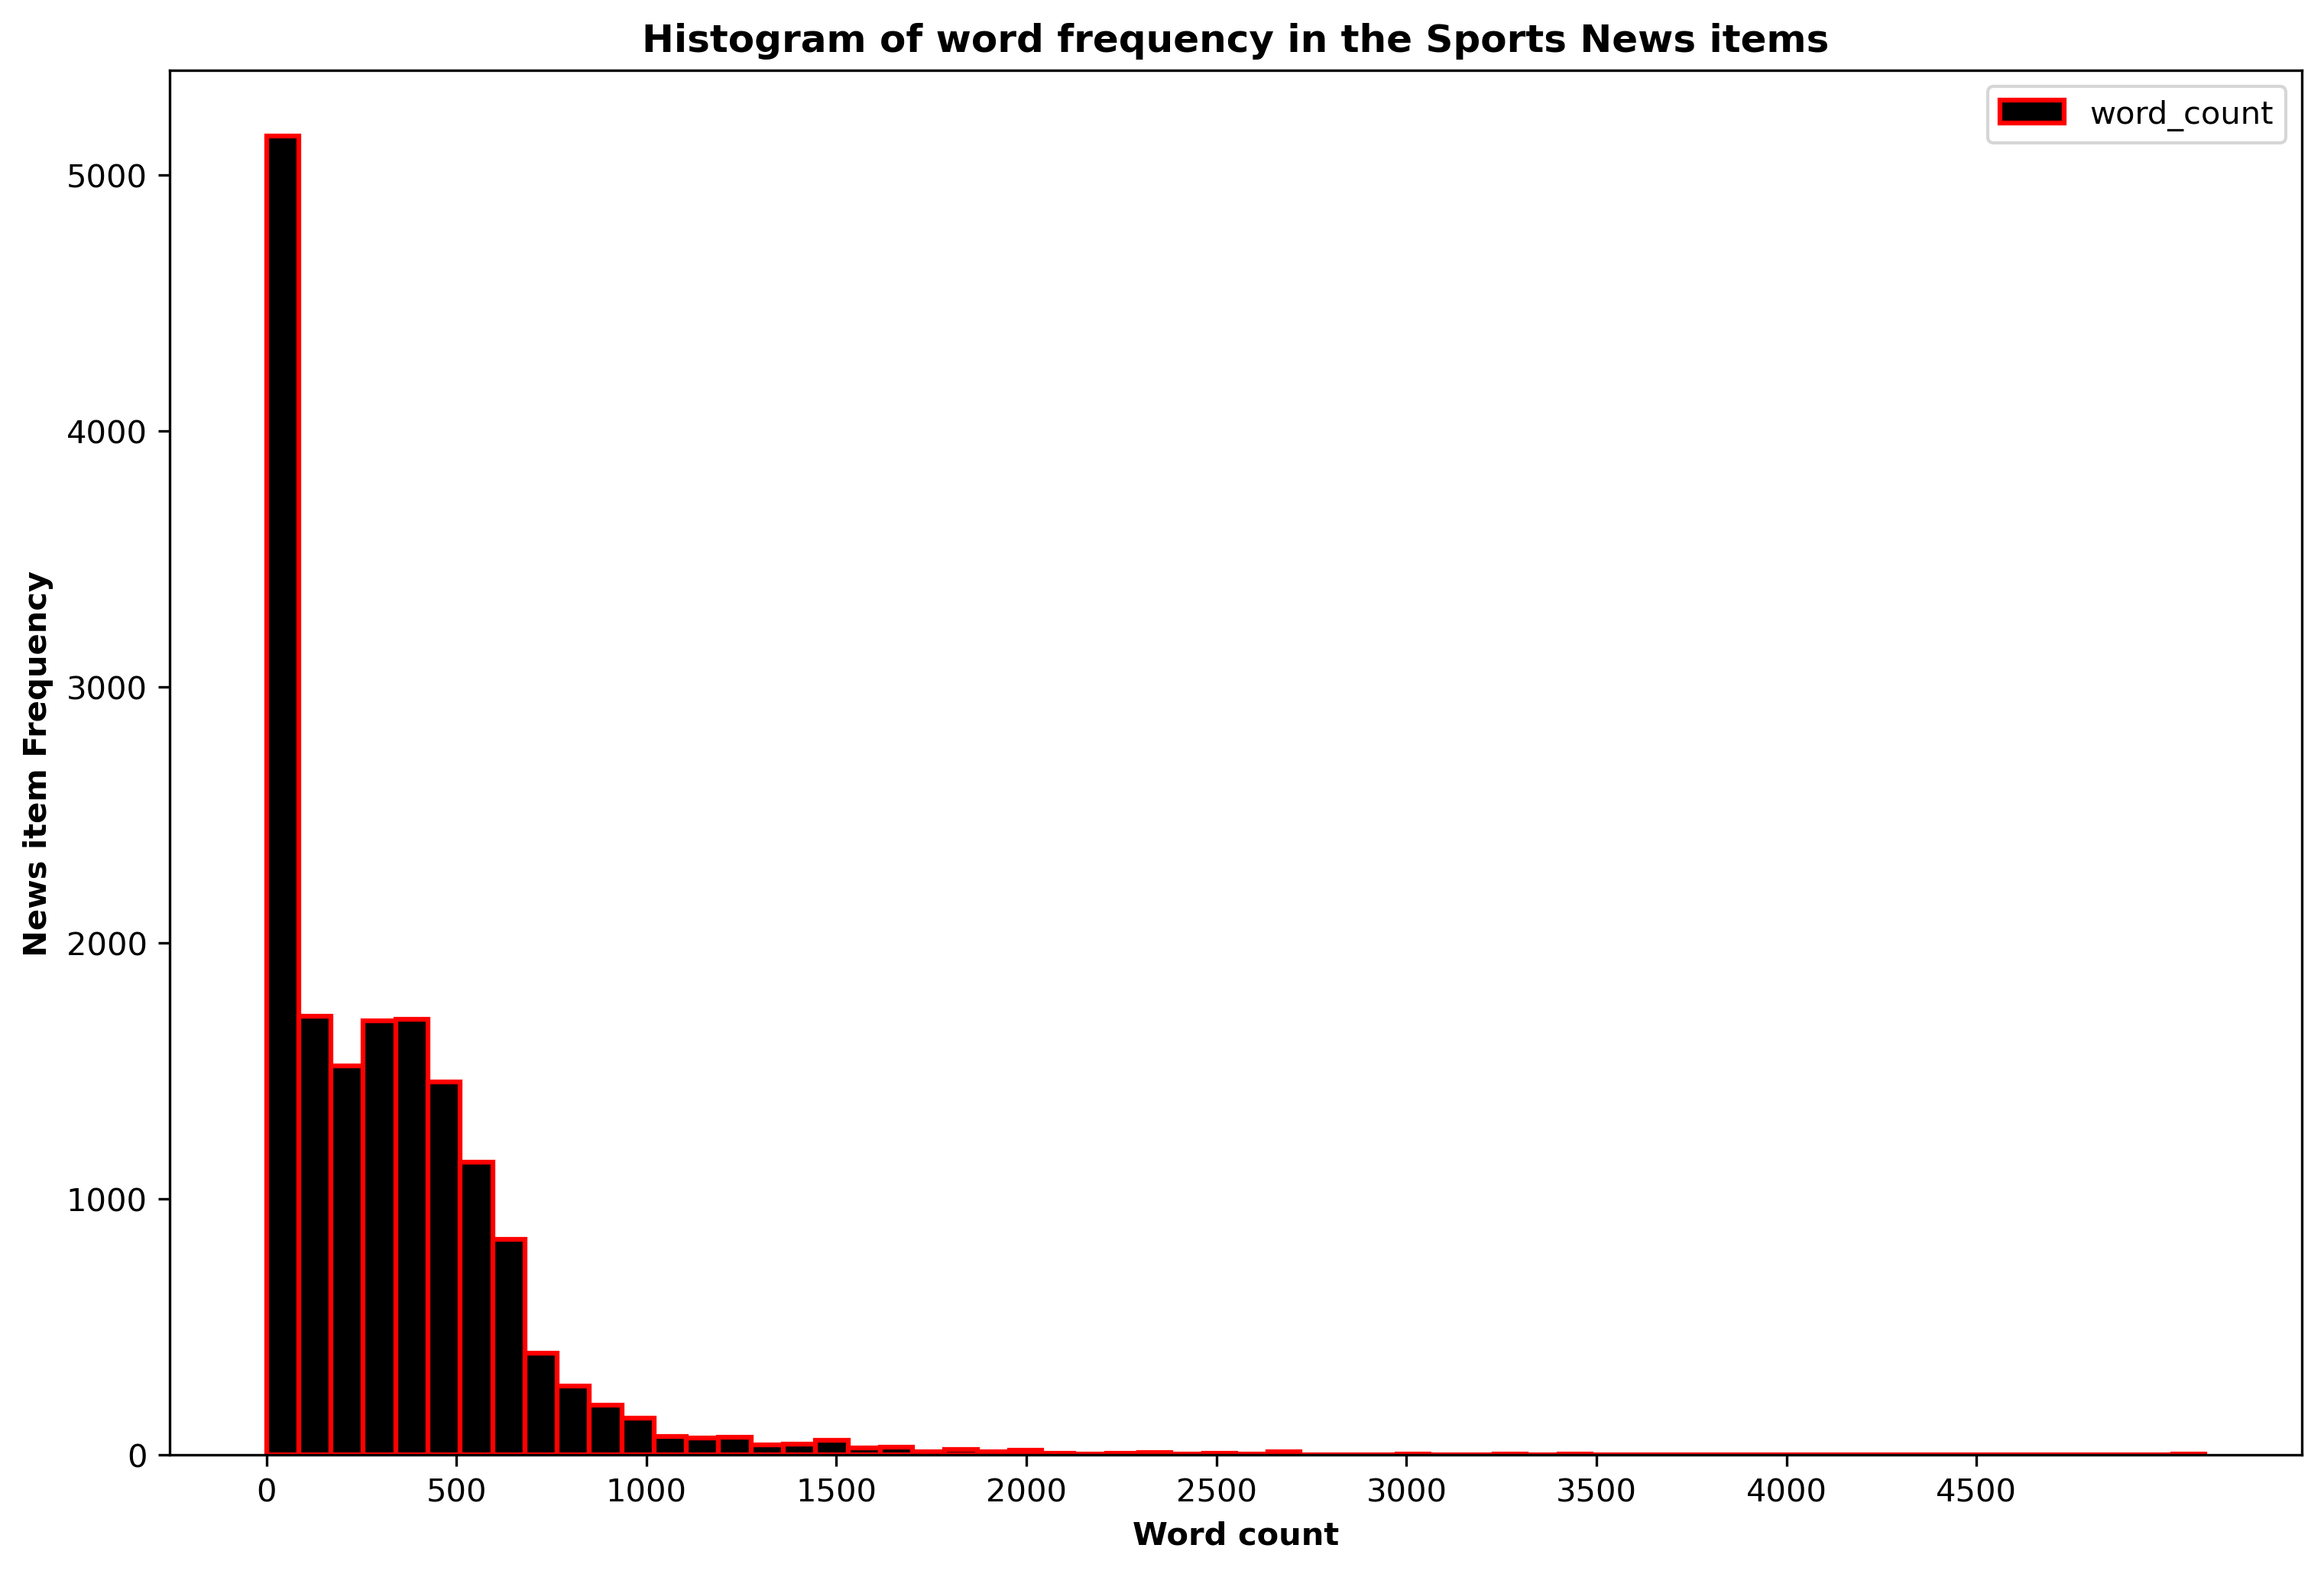

In [ ]:
# The distribution of lengths in tokens of the new items

df = pd.DataFrame({"word_count": word_count})

ax = df.plot.hist(column=["word_count"], figsize=(12, 8), bins=60, color ='black', edgecolor='red', linewidth=1.5)

plt.title("Histogram of word frequency in the Sports News items",fontweight ="bold")
plt.xlabel("Word count",fontweight ="bold")
plt.ylabel("News item Frequency",fontweight ="bold")

plt.xticks(np.arange(0, 5000, 500))
plt.gcf().set_dpi(300)

plt.show()

Briefly look into the new Dataset after extracting the content from the External Articles

In [ ]:
# Read the Raw data collected and Breif look at the dataset collected
df_content = pd.read_csv('Twitter_Data_withContent.csv')

# Adding column name to the respective columns
df_content.columns =['Tweet Id', 'Tweet url', 'Tweet Article Content']

# Display the Total number of records in the Dataset
print("-"*100)
print("Total number of records in the Dataset :" , len(df_content)+1)

----------------------------------------------------------------------------------------------------
Total number of records in the Dataset : 16747


In [ ]:
#Display the first 10 rows
print("-"*100)
print("First 10 rows of the DataFrame :")
display(df_content.head(10))

----------------------------------------------------------------------------------------------------
First 10 rows of the DataFrame :


Tweet Id                Tweet url  \
0  1477053195121664004  https://t.co/WngPr152Th   
1  1477046797314912256  https://t.co/WngPr152Th   
2  1476987770677731330  https://t.co/aRFzDBpMfQ   
3  1476977722211635213  https://t.co/48GBfIaunf   
4  1476961464917413893  https://t.co/CPDKNxoJ9v   
5  1476958829820661765  https://t.co/RS7ZHLsYmr   
6  1476950273335566343  https://t.co/6Erw9d4w8Q   
7  1476946295768203265  https://t.co/GgBSQSfzw8   
8  1476942481757548547  https://t.co/9KkyXzZQaI   
9  1476931759392579588  https://t.co/fMt0CtT5Sq   

                               Tweet Article Content  
0  ICC.tv - Watch Cricket Live or On-Demand\nSTRE...  
1  ICC.tv - Watch Cricket Live or On-Demand\nSTRE...  
2  Wales star Dan Biggar fearful of Six Nations w...  
3  India fined for slow over-rate after first Tes...  
4  ICC.tv - Watch Cricket Live or On-Demand\nSTRE...  
5  Gerrard does not want to see Tuanzebe return t...  
6  Premier League stars set for 'exceptional' Afr...  
7  The U19 cricket wrap\nAhead of the ICC Under 1...  
8  Lizelle Lee lines up for top ICC award, Jannem...  
9  Liverpool's Klopp confident Chelsea game will ...

In [ ]:
# Print Bottom 10 records
print("-"*100)
print("Last 10 rows of the DataFrame :")
display(df_content.tail(10))

----------------------------------------------------------------------------------------------------
Last 10 rows of the DataFrame :


Tweet Id                Tweet url  \
16736  1348005078247026688  https://t.co/ysCv0w9itu   
16737  1348004115247366145  https://t.co/mZzbfYxgDK   
16738  1348003159369797634  https://t.co/OhNeXcL6bw   
16739  1348000339623096326  https://t.co/umZjffeDBO   
16740  1347996570021629952  https://t.co/3KZHwpCfmo   
16741  1347995074152562688  https://t.co/ciKQ2TbIlg   
16742  1347992789653590018  https://t.co/kfeL9KXIvj   
16743  1347989015119716352  https://t.co/6XVYv5jEH7   
16744  1347985239998558208  https://t.co/40frkHHBYh   
16745  1347981469021515777  https://t.co/caX08S7JYK   

                                   Tweet Article Content  
16736  Striker Austin rejoins QPR on loan\nLast updat...  
16737  Hairdryers, Adele and penalties - Saturday's F...  
16738  Six Nations set for crunch talks after French ...  
16739  Bristol beat Exeter to go top of table\nLast u...  
16740  Bristol City-Brighton off because of Covid\nLa...  
16741  We can't make excuses, says Chiefs coach Gavin...  
16742  Secret Reprieve wins Welsh National\nLast upda...  
16743  Watson out of Abu Dhabi Open\nLast updated on ...  
16744  Blackpool shock WBA in FA Cup shootout\nLast u...  
16745  Schalke win to avoid unwanted record\nLast upd...

In [ ]:
# View the Data type of the columns in the dataset.
print("-"*100)
print("Column Data types :")
df_content.info()

----------------------------------------------------------------------------------------------------
Column Data types :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16746 entries, 0 to 16745
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Tweet Id               16746 non-null  int64 
 1   Tweet url              16746 non-null  object
 2   Tweet Article Content  16746 non-null  object
dtypes: int64(1), object(2)
memory usage: 392.6+ KB


In [ ]:
# Handling missing values
# Identify any null values for each column
print("-"*100)
print("Print the number of null values for each column :")
df_content.isnull().sum()

----------------------------------------------------------------------------------------------------
Print the number of null values for each column :


Tweet Id                 0
Tweet url                0
Tweet Article Content    0
dtype: int64

As you can notice, there are no Null values in the dataset. So, that we do not need to drop or 
modify any rows

### Answer (c)


(c) Using a suitable mechanism identify possible duplicates (or near duplicates) and remove them from the dataset. Describe the resulting deduplicated dataset as in (b)  above.

How duplicates were identified :

Since the Twitter_Data_withContent.csv has many duplicated records, I have to clean up the records to find the duplicated records and remove them from the dataset and store the final dataset in a separate CSV called Deduplicated_data.csv. I've used document clustering for this purpose and cleaned the data afterward.

Cleaning the Dataset consists: <br>
1- Removing Stopwords - They are words that you do not want to use to describe the topic of your content. <br>
2- Lemmatization - It is the grouping together of different forms of the same word. <br>
3- POS tag - Par-Of-Speech <br>
4- Removing Special Characters from the text. <br>

In the below cell, I have copied the contraction.py, normalization.py, utils.py and made some changes to fit the requirement. 

In [ ]:
# contractions.py
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

# normalization.py
stopword_list = nltk.corpus.stopwords.words('english')
# We need to extend the stopword list for the domain we are working with
stopword_list = stopword_list + ['mr', 'mrs', 'come', 'go', 'get',
                                 'tell', 'listen', 'one', 'two', 'three',
                                 'four', 'five', 'six', 'seven', 'eight',
                                 'nine', 'zero', 'join', 'find', 'make',
                                 'say', 'ask', 'tell', 'see', 'try', 'back',
                                 'also' , 'v', 'u', 'sa', 'yes', 'yet', 'able', 
                                 'al', 'bok', 'de', 'la', 'vs']
wnl = WordNetLemmatizer()
html_parser = HTMLParser()


def tokenize_text(text):
    tokens = nltk.word_tokenize(text) 
    tokens = [token.strip() for token in tokens]
    return tokens

def expand_contractions(text, contraction_mapping):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text
    
    
# from pattern.en import tag (if using python 2.x only)
from nltk.corpus import wordnet as wn

# Annotate text tokens with POS tags
def pos_tag_text(text):
    
    def penn_to_wn_tags(pos_tag):
        if pos_tag.startswith('J'):
            return wn.ADJ
        elif pos_tag.startswith('V'):
            return wn.VERB
        elif pos_tag.startswith('N'):
            return wn.NOUN
        elif pos_tag.startswith('R'):
            return wn.ADV
        else:
            return None

    tokens = nltk.word_tokenize(text)
    tagged_text = nltk.pos_tag(tokens)

#    tagged_text = tag(text) # If using pattern.en in python 2.x only
    tagged_lower_text = [(word.lower(), penn_to_wn_tags(pos_tag))
                         for word, pos_tag in
                         tagged_text]
    return tagged_lower_text
    
# lemmatize text based on POS tags    
def lemmatize_text(text):
    
    pos_tagged_text = pos_tag_text(text)
    lemmatized_tokens = [wnl.lemmatize(word, pos_tag) if pos_tag
                         else word                     
                         for word, pos_tag in pos_tagged_text]
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text
    

def remove_special_characters(text):
    tokens = tokenize_text(text)
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
    filtered_tokens = filter(None, [pattern.sub(' ', token) for token in tokens])
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text
    
    
def remove_stopwords(text):
    tokens = tokenize_text(text)
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

def keep_text_characters(text):
    filtered_tokens = []
    tokens = tokenize_text(text)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

def unescape_html(parser, text):
    return parser.unescape(text)

# We generalize our normalize function to be able to focus on text tokens alone - 3rd parameter
def normalize_corpus(corpus, lemmatize=True, only_text_chars=False, tokenize=False):
    
    normalized_corpus = []    
    for text in corpus:
        text = re.sub(r'https?://\S+', '', text)
        text = expand_contractions(text, CONTRACTION_MAP)
        if lemmatize:
            text = lemmatize_text(text)
        else:
            text = text.lower()
        text = remove_special_characters(text)
        text = remove_stopwords(text)
        # In case we only need to consider text tokens - ignoring numerical tokens for instance
        if only_text_chars:
            text = keep_text_characters(text) 
        
        if tokenize:
            text = tokenize_text(text)
            normalized_corpus.append(text)
        else:
            normalized_corpus.append(text)
            
    return normalized_corpus


def parse_document(document):
    document = re.sub('\n', ' ', document)
    if isinstance(document, str):
        document = document
    elif isinstance(document, encodingf='utf-8'):
        return unicodedata.normalize('NFKD', document).encode('ascii', 'ignore')
    else:
        raise ValueError('Document is not string or unicode!')
    document = document.strip()
    sentences = nltk.sent_tokenize(document)
    sentences = [sentence.strip() for sentence in sentences]
    return sentences
    

# utils.py
def build_feature_matrix(documents, feature_type='frequency',
                         ngram_range=(1, 1), min_df=0.0, max_df=1.0):

    feature_type = feature_type.lower().strip()  
    
    if feature_type == 'binary':
        vectorizer = CountVectorizer(binary=True, min_df=min_df,
                                     max_df=max_df, ngram_range=ngram_range)
    elif feature_type == 'frequency':
        vectorizer = CountVectorizer(binary=False, min_df=min_df,
                                     max_df=max_df, ngram_range=ngram_range)
    elif feature_type == 'tfidf':
        vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, 
                                     ngram_range=ngram_range)
    else:
        raise Exception("Wrong feature type entered. Possible values: 'binary', 'frequency', 'tfidf'")

    feature_matrix = vectorizer.fit_transform(documents).astype(float)
    
    return vectorizer, feature_matrix

Here, I am reading the Twitter_Data_withContent.csv and adding the records to an array. Later, normalize_corpus method is used to nomalize the data which eliminates the special characters in the Text, POS tags, tokenizing , contraction expanding.

In [ ]:
# Read file
read_obj_tweet_content = open('Twitter_Data_withContent.csv', 'r', encoding="utf-8")
csv_reader_tweet_content = reader(read_obj_tweet_content)

# Store the Twitter article content to an array
all_documents = []

for idx, row in enumerate(csv_reader_tweet_content):
    all_documents.append(row[2])

# We normalize and extract features from the whole corpus - all documents
norm_corpus = normalize_corpus(all_documents, lemmatize=True, only_text_chars=True)

# As before it returns the particular 'vectorizer' used as well as the extracted feature matrix
tfidf_vectorizer, tfidf_features = build_feature_matrix(norm_corpus,
                                                        feature_type='tfidf',
                                                        ngram_range=(1, 1), 
                                                        min_df=0.0, 
                                                        max_df=1.0)

Reason for choosing this -

Compared to Hellinger-Bhattacharya and BM25, I thought cosine-similarity metrics, would choose this requirement, as they can easily calculate the similarity between the documents. After getting the normalized content, I have built the feature matrix using the 'cosine-similarity' metrics through TF-IDF for each Sports news. 

TD-IDF - Term frequency-inverse document frequency is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. <br> 

As an output we can get the similarity between each document as a score, after finding out the top similarity score, I have chosen 0.7 to set as a limit (sim_score). So, I had to remove the documents which have a similarity score of above 0.7, But there was a drawback behind this approach as this may cause a loss of data. So that I created vocabulary in form of a structure to capture the documents along with similar documents indexes. After that, it ran through a loop to identify the duplicates and keep only 1 unique record.

In [ ]:
#Cosine similarity defines vector similarity in terms of the angle separating two vectors.
def compute_cosine_similarity(doc_features, corpus_features):
    # Get document vectors
    doc_features = doc_features[0]
        
    # Compute similarities by calling dot.product on transposed corpus feature vector
    similarity = np.dot(doc_features, corpus_features.T)
    similarity = similarity.toarray()[0]
    
    # Get docs with highest similarity scores
    top_docs = similarity.argsort()[::-1]
    top_docs_with_score = [(index, round(similarity[index], 3))
                            for index in top_docs]
    
    return top_docs_with_score

similiar_mapping = {}

for index, doc in enumerate(all_documents):
    doc_tfidf = tfidf_features[index]
    top_similar_docs = compute_cosine_similarity(doc_tfidf,tfidf_features)
    
    similiar_mapping[index] = []
    #print('Document',index+1 ,':', doc)
    #print('-'*40)
    for doc_index, sim_score in top_similar_docs:
        if(index == doc_index):
            continue
        if(sim_score > 0.7):
            similiar_mapping[index].append(doc_index)   

print(similiar_mapping)

After finding out the duplicate data from the Dataset, I have created an array and marked all the duplicate values as X (to remove all by keeping only one) and put to the final CSV called Deduplicated_data.csv

In [ ]:
for doc_i in similiar_mapping:
    if(len(similiar_mapping[doc_i]) > 0 and similiar_mapping[doc_i][0] !='X'):
        for remove_id in similiar_mapping[doc_i]:
            similiar_mapping[remove_id] = list('X'*len(similiar_mapping[remove_id]))


This shows the Number of records before and after removing the duplicate records.

In [ ]:
# Read the deduplicated data
read_dedup = open('Deduplicated_data.csv', 'r', encoding="utf-8")
csv_reader_read_dedup = reader(read_dedup)

# If the character X is identified ignore that Index and write the rest to the CSV
for idx, row in enumerate(csv_reader_read_with_content):
    for doc_i in similiar_mapping:
        if len(similiar_mapping[doc_i]): 
            if idx == doc_i and similiar_mapping[doc_i][0] != 'X':
                csv_reader_read_dedup.writerow(row)
        elif idx == doc_i:
            csv_reader_read_dedup.writerow(row)

read_dedup.close()

# Find the Row count of the new CSV
row_count = sum(1 for row in reader(open('Deduplicated_data.csv', 'r', encoding="utf-8")))

In [ ]:
# Compare the Original Dataset vs Deduplicated Dataset
df_content1 = pd.read_csv('Twitter_Data_withContent.csv')
df_content2 = pd.read_csv('Deduplicated_data.csv')

print("The number of records in the Original Dataset     : ", len(df_content1)+1)
print("The number of records in the Deduplicated Dataset : ", len(df_content2)+1)

The number of records in the Original Dataset     :  16747
The number of records in the Deduplicated Dataset :  10544


Describe the final dataset dimensions...

The Number of records dropped from 16747 to 10544 after the similarity check.

'describeData' method which I've created before shows the New items in the Dataset, Total number of words and the Total number of unique words.

In [ ]:
# Read the deduplicated CSV 
read_dedup = open('Deduplicated_data.csv', 'r', encoding="utf-8")
csv_reader_read_dedup = reader(read_dedup)

# Get the word count
word_count = describeData(csv_reader_read_dedup)

Number of news items in the dataset :  10542
Total number of words               :  4272007
The number of unique words          :  164043


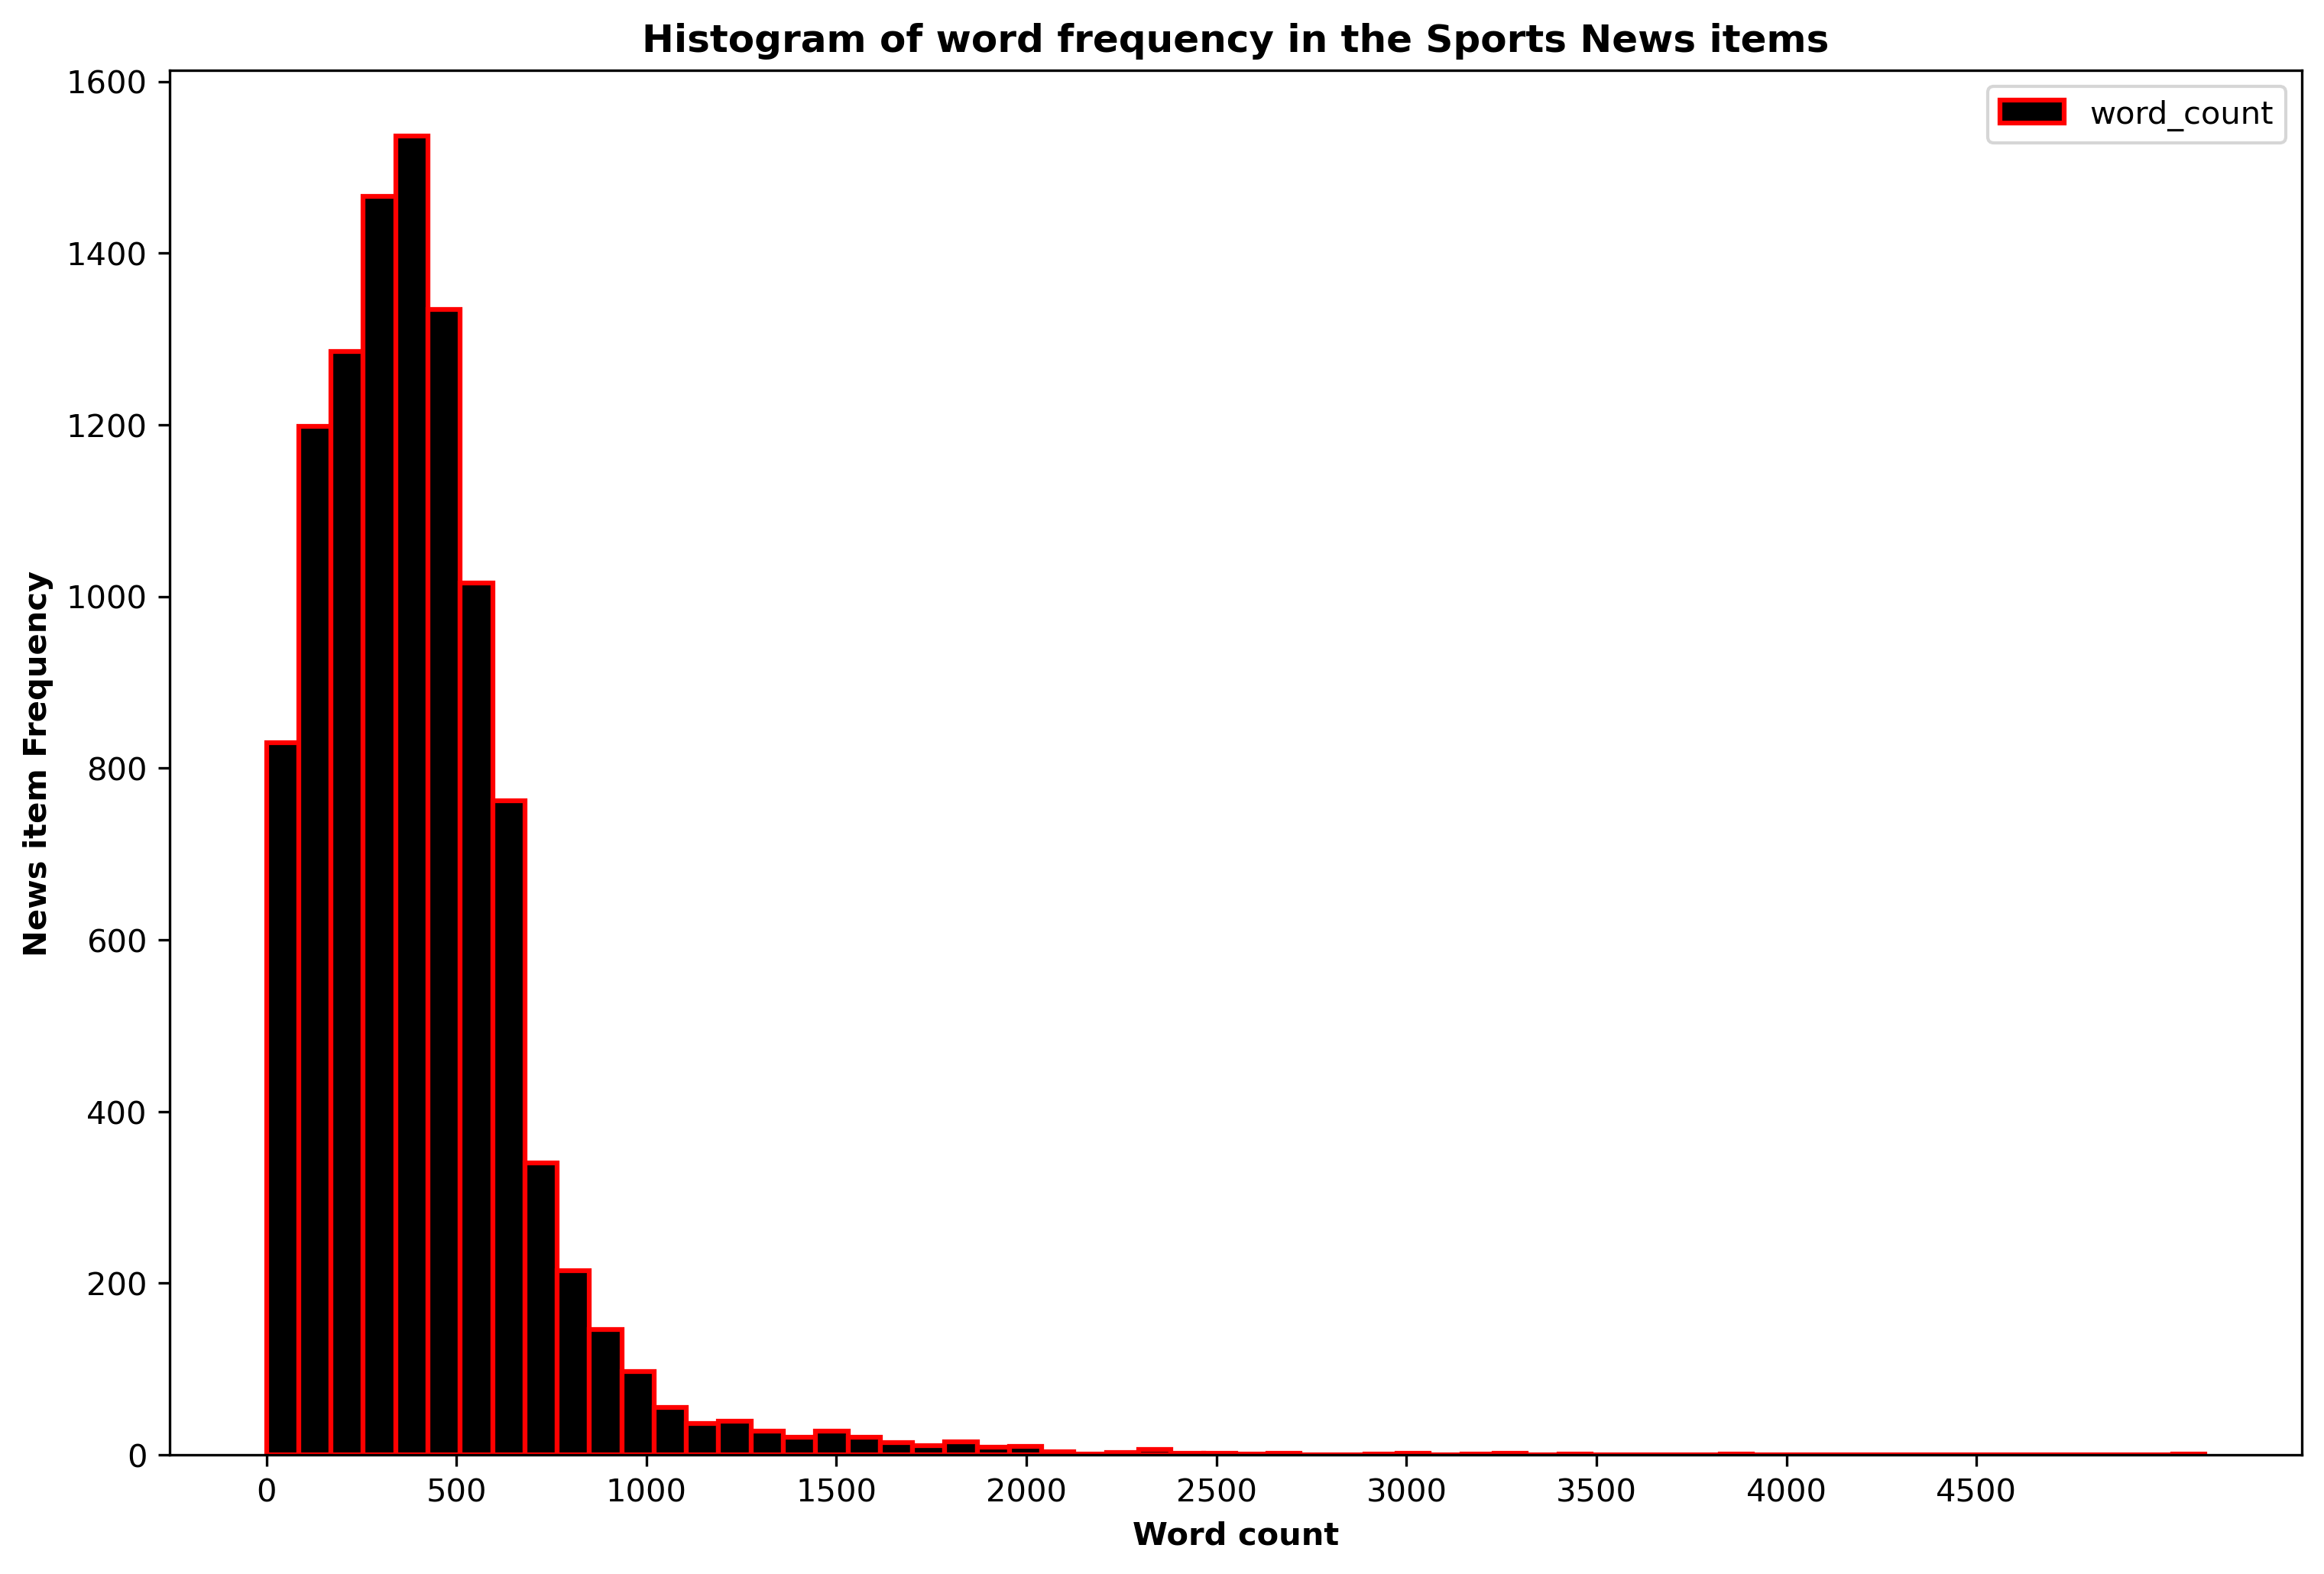

In [ ]:
# The distribution of lengths in tokens of the new items
# Representation using Histogram 

df = pd.DataFrame({"word_count": word_count})

ax = df.plot.hist(column=["word_count"], figsize=(12, 8), bins=60, color ='black', edgecolor='red', linewidth=1.5)

plt.title("Histogram of word frequency in the Sports News items",fontweight ="bold")
plt.xlabel("Word count",fontweight ="bold")
plt.ylabel("News item Frequency",fontweight ="bold")

plt.xticks(np.arange(0, 5000, 500))
plt.gcf().set_dpi(300)

plt.show()

### Answer (d)

(d) Check the nature of the dataset and take any action required to clean the dataset. Tokenize the news items and preprocess the data for feature extraction.

Describe what steps were taken upto this point :

1- Special Characters were removed <br>
2- URLs were removed becaus ethey do not provide any useful infromation for the Sports new content. <br>
3- Contractions were expanded. <br>
4- Lemmatization.<br>
5- Texts were converted to lower case. <br>
6- Removed stopwords - stopword_list <br>
7- Text were tokenzied using - nltk.tokenize function. <br>

I've shown the Brief look into the 'Deduplicated_data.csv' further.


In [ ]:
df_dedup = pd.read_csv('Deduplicated_data.csv')

# Adding column name to the respective columns
df_dedup.columns =['Tweet Id', 'Tweet URL', 'Tweet Content']

# Display the Total number of records in the Dataset
print("-"*100)
print("Total number of records in the Original Dataset     :" , len(df_content)+1)

print("-"*100)
print("Total number of records in the Deduplicated Dataset :" , len(df_dedup)+1)

----------------------------------------------------------------------------------------------------
Total number of records in the Original Dataset     : 16747
----------------------------------------------------------------------------------------------------
Total number of records in the Deduplicated Dataset : 10544


In [ ]:
#Display the first 10 rows
print("-"*100)
print("First 10 rows of the DataFrame :")
display(df_dedup.head(10))

----------------------------------------------------------------------------------------------------
First 10 rows of the DataFrame :


Tweet Id                Tweet URL  \
0  1476987770677731330  https://t.co/aRFzDBpMfQ   
1  1476977722211635213  https://t.co/48GBfIaunf   
2  1476958829820661765  https://t.co/RS7ZHLsYmr   
3  1476950273335566343  https://t.co/6Erw9d4w8Q   
4  1476946295768203265  https://t.co/GgBSQSfzw8   
5  1476942481757548547  https://t.co/9KkyXzZQaI   
6  1476931759392579588  https://t.co/fMt0CtT5Sq   
7  1476924566647840769  https://t.co/2ipLmv5ogD   
8  1476922842637737985  https://t.co/cmnKkpTW9V   
9  1476918949782724640  https://t.co/KUqBGFXscq   

                                       Tweet Content  
0  Wales star Dan Biggar fearful of Six Nations w...  
1  India fined for slow over-rate after first Tes...  
2  Gerrard does not want to see Tuanzebe return t...  
3  Premier League stars set for 'exceptional' Afr...  
4  The U19 cricket wrap\nAhead of the ICC Under 1...  
5  Lizelle Lee lines up for top ICC award, Jannem...  
6  Liverpool's Klopp confident Chelsea game will ...  
7  Diplomatic boycott of Beijing Games is 'meanin...  
8  Southampton-Newcastle match postponed due to C...  
9  'This could be it': Roethlisberger prepares fo...

In [ ]:
# Print Bottom 10 records
print("-"*100)
print("Last 10 rows of the DataFrame :")
display(df_dedup.tail(10))

----------------------------------------------------------------------------------------------------
Last 10 rows of the DataFrame :


Tweet Id                Tweet URL  \
10533  1348038088291987459  https://t.co/AlbmBog8Y9   
10534  1348030933287505922  https://t.co/Bw0lAkyyOU   
10535  1348011665418293248  https://t.co/zXtNL11K1s   
10536  1348007889533890569  https://t.co/Yvl5hPiPs9   
10537  1348003159369797634  https://t.co/OhNeXcL6bw   
10538  1348000339623096326  https://t.co/umZjffeDBO   
10539  1347996570021629952  https://t.co/3KZHwpCfmo   
10540  1347995074152562688  https://t.co/ciKQ2TbIlg   
10541  1347992789653590018  https://t.co/kfeL9KXIvj   
10542  1347989015119716352  https://t.co/6XVYv5jEH7   

                                           Tweet Content  
10533  Blackpool shock WBA in FA Cup shootout\nLast u...  
10534  Real Madrid held by struggling Osasuna\nLast u...  
10535  Don't pick on footballers - Moyes\nLast update...  
10536  Burnley avoid shock MK Dons defeat\nLast updat...  
10537  Six Nations set for crunch talks after French ...  
10538  Bristol beat Exeter to go top of table\nLast u...  
10539  Bristol City-Brighton off because of Covid\nLa...  
10540  We can't make excuses, says Chiefs coach Gavin...  
10541  Secret Reprieve wins Welsh National\nLast upda...  
10542  Watson out of Abu Dhabi Open\nLast updated on ...

In [ ]:
# Handling missing values
# Identify any null values for each column
print("-"*100)
print("Print the number of null values for each column :")
df_dedup.isnull().sum()

----------------------------------------------------------------------------------------------------
Print the number of null values for each column :


Tweet Id         0
Tweet URL        0
Tweet Content    0
dtype: int64

Describe what happened...

The Dataset looks clean as I've used the normalize_corpus for the nomalization.py file. Bypassing the params for the dataset, lemmatization set to True (which lemmatize based on the POS tags), only_text_chars to True (which considers only the text token and not the numerical tokens), tokenize to True (which tokenizes the text nltk.word_tokenize).

Performed null check to explicitly handle the null values if any in the dataset, the output shows that we do not have any null values.

Now it is all set to Feature extraction!

### Answer (e)

(e) Perform feature extraction on the dataset by creating sparse and dense vector representations. Describe the final dataset(s) in terms of number of news items and number of features for each such feature extraction method. Randomly select 300 data points from this final dataset for testing.

In [ ]:
# feature_extractors.py
def do_nothing(tokens):
    return tokens

# The simplest feature extraction is to use bow - i.e. extract counts of unigrams
# Instead of a frequency bow, we can also use n-gram bow model - how?
# Try to extract trigram bows
def bow_extractor(corpus, ngram_range=(1,1)):
    
    vectorizer = CountVectorizer(min_df=1, 
                                 ngram_range=ngram_range, 
                                 tokenizer=do_nothing,  
                                 preprocessor=None, 
                                 lowercase=False)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features
    
    
from sklearn.feature_extraction.text import TfidfTransformer


# Weighting each term by how important it is in the document collection
# SAQ: How to calculate it yourself?
def tfidf_transformer(bow_matrix):
    
    transformer = TfidfTransformer(norm='l2',
                                   smooth_idf=True,
                                   use_idf=True)
    tfidf_matrix = transformer.fit_transform(bow_matrix)
    return transformer, tfidf_matrix
    
    
from sklearn.feature_extraction.text import TfidfVectorizer

# TfidfVectorizer is the powerful equivalent of CountVectorizer for TF-IDF weights
# SAQ: Can you see how you can use td-idf n-grams?
def tfidf_extractor(corpus, ngram_range=(1,1)):
    
    vectorizer = TfidfVectorizer(min_df=1, 
                                 norm='l2',
                                 smooth_idf=True,
                                 use_idf=True,
                                 ngram_range=ngram_range,
                                 tokenizer=do_nothing,
                                 preprocessor=None,
                                 lowercase=False)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features




# Two weighting schemes for combining word vectors in documents
# 1. averaging the word vectors
# 2. tf-idf weighting of word vectors

import numpy as np    
    
# Averaging word vectors of a document

def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.index_to_key)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)
    

# Using tfidf weighted average of word vectors in a document              

def tfidf_wtd_avg_word_vectors(words, tfidf_vector, tfidf_vocabulary, model, num_features):
    
    word_tfidfs = [tfidf_vector[0, tfidf_vocabulary.get(word)] 
                   if tfidf_vocabulary.get(word) 
                   else 0 for word in words]
    type(tfidf_vector)
    word_tfidf_map = {word:tfidf_val for word, tfidf_val in zip(words, word_tfidfs)}
    feature_vector = np.zeros((num_features,),dtype="float64")
    vocabulary = set(model.wv.index_to_key)
    wts = 0.
    for word in words:
        if word in vocabulary: 
            word_vector = model.wv[word]
            weighted_word_vector = word_tfidf_map[word] * word_vector
            wts = wts + word_tfidf_map[word]
            feature_vector = np.add(feature_vector, weighted_word_vector)
    if wts:
        feature_vector = np.divide(feature_vector, wts)
        
    return feature_vector
    
def tfidf_weighted_averaged_word_vectorizer(corpus, tfidf_vectors, 
                                   tfidf_vocabulary, model, num_features):
                                       
    docs_tfidfs = [(doc, doc_tfidf) 
                   for doc, doc_tfidf 
                   in zip(corpus, tfidf_vectors)]
    features = [tfidf_wtd_avg_word_vectors(tokenized_sentence, tfidf, tfidf_vocabulary,
                                   model, num_features)
                    for tokenized_sentence, tfidf in docs_tfidfs]
    return np.array(features)

# Method to display the features 
def display_features(features, feature_names):
    df = pd.DataFrame(data=features,columns=feature_names)
    print(df)

Here I've taken the deduplicated data stored in the CSV file and extracted the Tweet content from the file and stored in an array. Later I've used the random.shuffle method to split the data randomly to Testing and Training respectively and stored the data in two different files for Testing and Training.

In [ ]:
# ! Disclaimer !
#------------ RUN ONLY ONCE --------------#

# Read the deduplicated data and split the record to Training and Testing Dataset
read_obj1 = open('Deduplicated_data.csv', 'r', encoding="utf-8")
csv_reader_dup = reader(read_obj1)

# Write the records to the Testing dataset 
write_obj_test = open('Testing_dataset.csv', 'w', newline='', encoding="utf-8")
csv_writer_test = writer(write_obj_test)

# Write the records to the Training dataset 
write_obj_train = open('Training_dataset.csv', 'w', newline='', encoding="utf-8")
csv_writer_train = writer(write_obj_train)

# Array to hold all the Tweet content from the dataset
all_records = []

# Read the Tweet content which is in array 2 on loop
for idx, row in enumerate(csv_reader_read_dedup):
    all_records.append(row[2])
    
# Random shuffle records and extract 300 for the testing dataset
random.shuffle(all_records)

# Split arrays or matrices into random train and test subsets.
training_dataset, testing_dataset = sklearn.model_selection.train_test_split(all_records, 
                                                                          train_size=len(all_records)-300, 
                                                                          test_size=300) 

# Write the testing Dataset to the CSV
for test in testing_dataset:
    csv_writer_test.writerow([test])

# Write the training Dataset to the CSV
for train in training_dataset:
    csv_writer_train.writerow([train])


Now Let's look into the Dataset length and the dataset description seperately

In [ ]:
# Open Training Dataset
training_read_obj = open('Training_dataset.csv', 'r', encoding="utf-8")
training_reader = reader(training_read_obj)

# Open TestingDataset
testing_read_obj = open('Testing_dataset.csv', 'r', encoding="utf-8")
testing_reader = reader(testing_read_obj)

# Declared Array to hold the values seperately for each
training_records = []
testing_records = []

# Loop it using a for loop
for idx, row in enumerate(training_reader):
    training_records.append(row[0])
    
for idx, row in enumerate(testing_reader):
    testing_records.append(row[0])

# Normalize the dataset seperately 
training_dataset = normalize_corpus(training_records, lemmatize=True, only_text_chars=True, tokenize=True)
testing_dataset = normalize_corpus(testing_records, lemmatize=True, only_text_chars=True, tokenize=True)

# Print he length of the Dataset seperately
print("Testing Dataset count  : ",len(testing_dataset))
print("Training Dataset count : ",len(training_dataset))

Testing Dataset count  :  300
Training Dataset count :  10244


Describe how much data remained for model building...

Testing Dataset count  :  300 and Training Dataset count :  10244

In [ ]:
df_training = pd.read_csv('Training_dataset.csv')
df_testing = pd.read_csv('Training_dataset.csv')

# Adding column name to the respective columns
df_training.columns =['Tweet Content']
display(df_training.head(5))

Tweet Content
0  Anthony Joshua wants Oleksandr Usyk rematch '1...
1  The Ashes: Australia beat England by 275 runs ...
2  Rejigged fixtures for Australia-India campaign...
3  Champions League quarterfinal draw: Bayern Mun...
4  'Sad' Spurs stunned as Trossard boosts Brighto...

In [ ]:
# Adding column name to the respective columns
df_testing.columns =['Tweet Content']
display(df_testing.head(5))

Tweet Content
0  Anthony Joshua wants Oleksandr Usyk rematch '1...
1  The Ashes: Australia beat England by 275 runs ...
2  Rejigged fixtures for Australia-India campaign...
3  Champions League quarterfinal draw: Bayern Mun...
4  'Sad' Spurs stunned as Trossard boosts Brighto...

Describe what happened...

In this you can notice I've split the Dataset to two, where the Testing dataset carries 300 records and Training dataset carries 10244 records.

If we look in to the nature of the Dataset :
The Dataset looks clean and tokenzied.

Output : Now the Dataset is ready for the feature extraction.

# ------------------------------------------------


Describe what kind of feature extractions were done...

For this question I've performed the feature extraction by creating sparse and dense vector representation.

1- Sparse Vector Representation - BOW (Bag-Of-Words) Extraction and TF-IDF (Term Frequency-Inverse Document Frequency) Feature Extraction

Both BoW and TF-IDF are techniques that help us convert text sentences into numeric vectors.

Bag of Words (BoW) Model
----------------------------------------------------------

The Bag of Words (BoW) model is the simplest form of text representation in numbers. Like the term itself, we can represent a sentence as a bag of words vector (a string of numbers).


In [ ]:
# BOW Feature Extractor
print("-------- BOW Feature Extractor -------------")

# We pass our CORPUS to the simplest bow extractor we created    
bow_vectorizer, bow_features = bow_extractor(training_dataset)
# Remember, we always need to extract the same features from our test data too!
test_features = bow_vectorizer.transform(testing_dataset)

# Since we can't view the default 'sparse matrix'
# Training Data
train_features = bow_features.todense()
# print("Training Features : ",train_features)

# Testing Data
test_features = test_features.todense()
# print("Testing Features : ", test_features)

# Let's see which words/tokens these counts are for...
feature_names = bow_vectorizer.get_feature_names_out()
print('BOW Feature count :', len(feature_names))

# Let's print both the feature names and counts together
# first for the training data and then for the test data
# print("Training : ",train_features)
# display_features(train_features, feature_names)
# print("Testing : ")
# display_features(test_features, feature_names)

-------- BOW Feature Extractor -------------
BOW Feature count : 42815


Output Explanataion : It will first build the vacabulary using the unique words from the Tweets. The vocabulary consists of these 48815 words. 
[10244 rows x 42815 columns] = Training News Items x Number of features
[300 rows x 42815 columns] = Testing News Items x Number of features

If we closley examine those vectors, It gives Vector Tweets like this -

Training
Vector Tweet 1 - [0,0,0,0,0,0,0,.....,0]

Testing
Vector Tweet 1 - [0,0,0,0,0,0,0,.....,0]


Term Frequency-Inverse Document Frequency (TF-IDF) Model
----------------------------------------------------------

It is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.


In [ ]:
# TF-IDF Feature Extractor
print("---------- TF-IDF Feature Extractor ----------------")

# Funtion making sure not to tokenize
def do_nothing(tokens):
    return tokens

# TfidfVectorizer is the powerful equivalent of CountVectorizer for TF-IDF weights
# min_df - omits any rare words (less frequent)
# max-df - removes anything that is so common
vectorizer = TfidfVectorizer(min_df=0.03, max_df=0.5, ngram_range=(1,3), tokenizer=do_nothing, preprocessor=None, lowercase=False)

# It is used on the training data so that we can scale the training data and also learn the scaling parameters
feature_matrix = vectorizer.fit_transform(training_dataset).astype(float)

# Store feature names
feature_names = vectorizer.get_feature_names_out()

print("Training Dataset -  ")

# Output the shape of the feature-matrix
print('Feature Matrix Shape : ', feature_matrix.shape)     

# Print the Number of features
print("The Number of features : ", len(feature_names))
print("-"*100)

# -------------------------------------------------------------------

# It is used to transform a given text into a vector on the basis of the countof each word that occurs in the entire text
test_feature_matrix = vectorizer.transform(testing_dataset)

# Store feature names
feature_names_test = vectorizer.get_feature_names_out()

print("Testing Dataset -  ")

# Output the shape of the feature-matrix
print('Feature Matrix Shape : ', test_feature_matrix.shape)     

# Print the Number of features
print("The Number of features : ", len(feature_names_test))
print("-"*100)

---------- TF-IDF Feature Extractor ----------------
Training Dataset -  
Feature Matrix Shape :  (10244, 997)
The Number of features :  997
----------------------------------------------------------------------------------------------------
Testing Dataset -  
Feature Matrix Shape :  (300, 997)
The Number of features :  997
----------------------------------------------------------------------------------------------------


Ouput Explanation : <br>
Training Dataset
(10244, 997) = Training News Items x Number of features

Testing Dataset
(300, 997) = Training News Items x Number of features <br>

TF-IDF n-gram parameter has been set to (1,3) which is called trigram (Trigram is 3 consecutive words in a sentence) has been set other than unigram and bigram. Where we can get the proper meaning behind the split of words in a document.This can help us get a better outcome without having to process more on data. 
Example words : Premier League, football league system

2- Dense Representation - Word2Vec Feature Extractor

Word2Vec Model
----------------------------------------------------------

The Word2Vec models allow us to encode words in more meaningful ways and much more.


In [ ]:
# Word2Vec Feature Extractor
# We can also do more sophisticated word-vector models using Google's word2vec algorithm using the gensim python package

print("---------- Word2Vec Feature Extractor ----------------")

# Build word2vec model
word2vec_model = gensim.models.Word2Vec(training_dataset, vector_size=10, window=10, min_count=2, sample=1e-3)

vocab_len = len(word2vec_model.wv.index_to_key)
print("Word2Vec - Number of Feature count :", vocab_len)

# Train - Averaging word vectors of a document 
avg_word_vec_features = averaged_word_vectorizer(corpus=training_dataset, model=word2vec_model.wv, num_features=10)

# Test - Averaging word vectors of a document 
test_avg_word_vec_features = averaged_word_vectorizer(corpus=testing_dataset, model=word2vec_model.wv, num_features=10)

# Using tfidf weighted average of word vectors in a document 
corpus_tfidf = feature_matrix

# tfidf weighted averaged word vector features
vocab = vectorizer.vocabulary_

# Training Dataset
train_wt_tfidf_word_vec_features = tfidf_weighted_averaged_word_vectorizer(corpus=training_dataset,
                                                                     tfidf_vectors=corpus_tfidf,
                                                                     tfidf_vocabulary=vocab,
                                                                     model=word2vec_model, 
                                                                     num_features=10)
print("Training Dataset -  ")
print(np.round(train_wt_tfidf_word_vec_features, 3))

print("-"*100)

# Testing Dataset
test_wt_tfidf_word_vec_features = tfidf_weighted_averaged_word_vectorizer(corpus=testing_dataset,
                                                                     tfidf_vectors=test_feature_matrix,
                                                                     tfidf_vocabulary=vocab,
                                                                     model=word2vec_model, 
                                                                     num_features=10)
print("Testing Dataset -  ")
print(np.round(test_wt_tfidf_word_vec_features, 3))

---------- Word2Vec Feature Extractor ----------------
Word2Vec - Number of Feature count : 28267
Training Dataset -  
[[ 0.803 -2.993  1.596 ...  0.998 -1.923  1.024]
 [-2.024  1.2    2.86  ...  1.326 -1.946 -0.772]
 [ 0.15   1.793 -1.036 ...  3.398 -3.928  2.225]
 ...
 [ 1.457 -1.24   1.542 ...  1.374 -1.557 -1.039]
 [-3.003 -0.689  1.837 ...  1.322 -0.195 -2.396]
 [ 0.     0.     0.    ...  0.     0.     0.   ]]
----------------------------------------------------------------------------------------------------
Testing Dataset -  
[[-3.273e+00 -1.750e-01  2.600e-02 ...  1.905e+00 -2.384e+00 -5.690e-01]
 [ 2.330e-01 -1.950e-01  3.000e-03 ...  4.740e-01 -2.160e+00  4.860e-01]
 [ 2.700e-02 -9.670e-01  2.560e-01 ...  4.200e-01 -4.484e+00  2.834e+00]
 ...
 [ 1.983e+00 -9.860e-01  1.070e+00 ...  1.903e+00 -1.953e+00  3.250e-01]
 [ 4.612e+00 -2.356e+00  4.920e-01 ...  9.410e-01 -8.630e-01 -1.714e+00]
 [ 1.080e+00 -5.160e-01  1.078e+00 ... -2.320e+00 -3.665e+00  1.457e+00]]


Output Explanataion : Word2Vec shows 28267 features.

Conclusion from the above used three feature extractors -

The TF-IDF produced 997 features and Word2Vec produced 28267 features. So out from this, the TD-IDF has produced the most optimal features compared to BOW model (42815). So that I can use the TF-IDF to build the model.


### Answer (f)

(f) Using machine learning (From the scikit-learn library), categorize the rest of the news items in the dataset into an appropriate number of groups using any appropriate technique and justify the categorization scheme.

Describe what kind of machine learning was used for grouping news items...

In this question, it has asked to cluster and I will be using the unsupervised approach to achieve the goal. In this approach, we do not know what is the optimal number of clusters to be used, for that we have two main ways to determine the optimal number of clusters.

1- K-Means Clustering and plotting the "ELBOW method" - Sum of squared Distance Vs Cluster Number and see where the Elbow falls. This is considered to be a very popular technique in terms of visualization.

2- Affinity Propagation - To determine the optimal clusters, when we are not aware of the number of clusters.

To get the best output, first I've built the feature matrix using TF-IDF, using K-Means and the Elbow method to find the optimal number of clusters. Later, I used the Affinity Propagation algorithm to decide based on the results.

K-Means Clustering
----------------------------------------------------------




In [ ]:
# Function for K means clustering

# Define the k-means clustering function which will call sklearn's KMeans function with our parameters
def k_means(feature_matrix, num_clusters=5):
    km = KMeans(n_clusters=num_clusters, max_iter=10000, random_state=1)
    km.fit(feature_matrix)
    clusters = km.labels_
    return km, clusters

# Intialization Block
# Trained dataset not tokenzied was push to a dataframe
sports_data = pd.DataFrame (training_records, columns = ['news_items'])
# Array to handle the cleaned training data
cleaned_training = []

# Training dataset is iterated and was apened to cleaned traiinning array object
for row in training_dataset:
    clean_joined = " ".join(row)
    cleaned_training.append(clean_joined)

# the cleaned dataset was then included to news_items pandas object
sports_data_cleaned = pd.DataFrame (cleaned_training, columns = ['news_items'])

print("----------- Cleaned Data ---------")
display(sports_data_cleaned.head(10))

----------- Cleaned Data ---------


news_items
0  argentina defeat colombia penalty reach copa a...
1  anthony joshua want oleksandr usyk rematch per...
2  ash australia beat england run adelaide test a...
3  rejigged fixture australia india campaign anno...
4  champion league quarterfinal draw bayern munic...
5  sad spur stun trossard boost brighton jose mou...
6  uefa action german keeper neuers rainbow armba...
7  india england 4th test icc sorry currently vid...
8  sancho victim solskjaers struggle strike right...
9  injured djokovic slam quarantine suggest nba s...

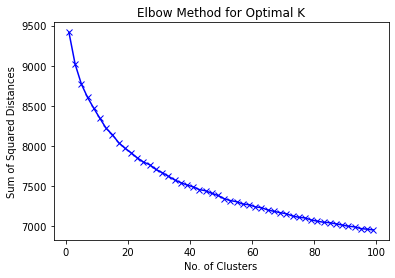

In [ ]:
# Here we run the elbow method and we are considering from 1 to 100, so run the KM clustering for 100 times.
# each time we are changing the number of clusters, using the np.arrange which is one of the array creation routines based on 
# numerical ranges
# Lets use the ELBOW METHOD to find the optimal number of clusters 
k_vals = np.arange(1,100,2).tolist()
sum_of_squared_distances = []

# Loop to identify the k values to plot k_values and sum_of_sqaured_distances
for k in k_vals:
    km_obj, clusters = k_means(feature_matrix=feature_matrix, num_clusters=k)
    sum_of_squared_distances.append(km_obj.inertia_)

# After it runs 100 times, we will be plottinf the elbow method gaph based on the k values
plt.plot(k_vals, sum_of_squared_distances, 'bx-')
plt.xlabel('No. of Clusters')
plt.ylabel("Sum of Squared Distances")
plt.title("Elbow Method for Optimal K")
plt.show()

Output Explanataion : The elbow method recommends 50 clusters (approx), as the curve points the elbow at that point.

Affinity Propagation
----------------------------------------------------------




In [ ]:
# We now repeat the steps of performing clustering using a different algorithm: AP
def affinity_propagation(feature_matrix):
    sim = feature_matrix * feature_matrix.T
    sim = sim.todense()
    ap = AffinityPropagation(random_state=42)
    ap.fit(np.asarray(sim))
    clusters = ap.labels_          
    return ap, clusters

# Get clusters using affinity propagation (AP)
ap_obj, apclusters = affinity_propagation(feature_matrix=feature_matrix)
print("Affinity Propagation")
sports_data['Cluster_AP'] = apclusters

# Get the total number of features per cluster
c = Counter(apclusters)   
# print(c.items())

# How many clusters are there in total?
total_clusters = len(c)
print('Total Clusters:', total_clusters)


Affinity Propagation
Total Clusters: 388


Describe what the resulting number of categories was...

Output Explanation: The Affinity Propagation shows 388 clusters, which is considered too much for this requirement. Because in the next section, I'd need to manually annotate the records mapping to each Sport Item.

As a result, I will consider the K-Mean clustering algorithm and the output 50 as the Total number of clusters and proceed with it.

In [ ]:
# We define a generic function to extract details of the clusters we get (from each of our algorithms)
def get_cluster_data(clustering_obj, review_data, feature_names, num_clusters, topn_features=10):
    cluster_details = {}  
    # Get cluster centroids
    ordered_centroids = clustering_obj.cluster_centers_.argsort()[:, ::-1]
    # Get key features for each cluster
    # Get reviews belonging to each cluster
    for cluster_num in range(num_clusters):
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster_num'] = cluster_num
        key_features = [feature_names[index] 
                        for index 
                        in ordered_centroids[cluster_num, :topn_features]]
        cluster_details[cluster_num]['key_features'] = key_features
        
        sports = review_data[review_data['Cluster_KM'] == cluster_num]['news_items'].values.tolist()
        cluster_details[cluster_num]['sports'] = sports
    
    return cluster_details

# We also define a simple function to print the data we extracted with the above function
def print_cluster_data(cluster_data):
    # Print cluster details
    for cluster_num, cluster_details in cluster_data.items():
        print('Cluster {} details:'.format(cluster_num))
        print('-'*20)
        print('Key features:', cluster_details['key_features'])
        print('='*40)

# Get clustering analysis data using our generic function
# Here we are going to give the exact cluster which is 50 in my case...
km_obj, kclusters = k_means(feature_matrix=feature_matrix,num_clusters=50)

# Identify the sport grouped clusters
sports_data['Cluster_KM'] = kclusters
cluster_data =  get_cluster_data(clustering_obj=km_obj,
                                 review_data=sports_data,
                                 feature_names=feature_names,
                                 num_clusters=50,
                                 topn_features=10)

# Display identified cluster data
print_cluster_data(cluster_data)

Cluster 0 details:
--------------------
Key features: ['springbok', 'boks', 'rugby', 'test', 'coach', 'rugby championship', 'saturday', 'week', 'lion', 'argentina']
Cluster 1 details:
--------------------
Key features: ['wicket', 'ball', 'run', 'india', 'inning', 'bat', 'century', 'delivery', 'ireland', 'day']
Cluster 2 details:
--------------------
Key features: ['england', 'test', 'australia', 'cricket', 'wicket', 'series', 'ball', 'australian', 'inning', 'day']
Cluster 3 details:
--------------------
Key features: ['erasmus', 'rugby', 'rassie', 'referee', 'lion', 'springbok', 'director rugby', 'video', 'director', 'world']
Cluster 4 details:
--------------------
Key features: ['chief', 'kaizer', 'kaizer chief', 'league', 'club', 'coach', 'season', 'champion league', 'goal', 'player']
Cluster 5 details:
--------------------
Key features: ['england', 'euro', 'italy', 'final', 'world cup', 'world', 'cup', 'penalty', 'goal', 'tournament']
Cluster 6 details:
--------------------
Key feat

Output Explanataion : Here, I've printed the top 10 key features identified from each cluster. Eventhough it shows the top 10 features, It is bit tugh to gudge the sport based on the Key words.

K-Means Clusters


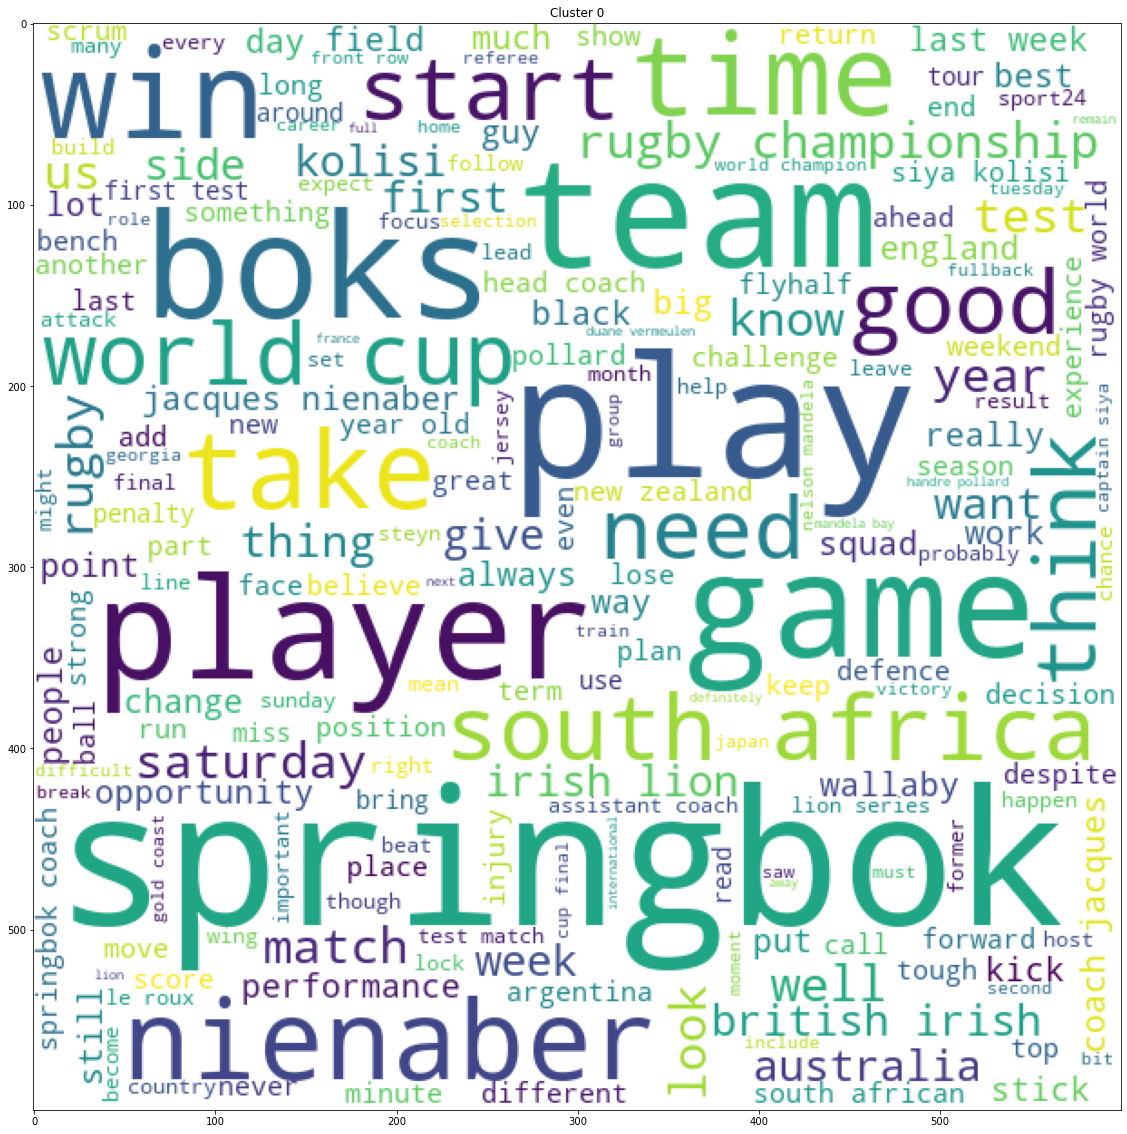

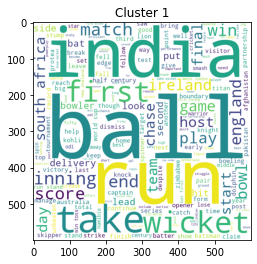

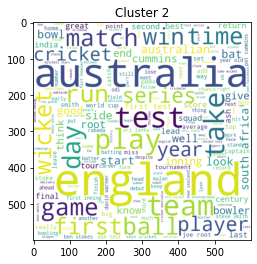

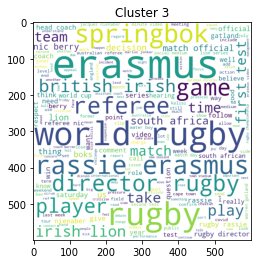

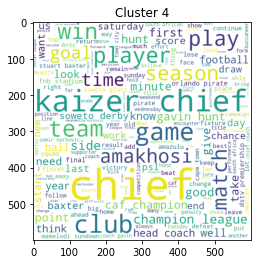

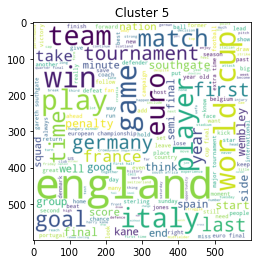

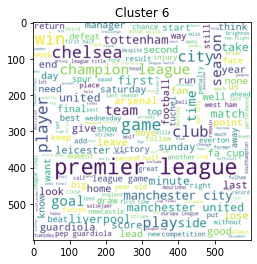

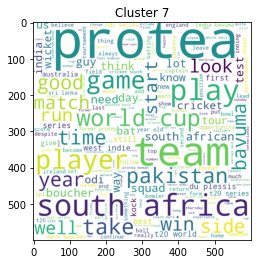

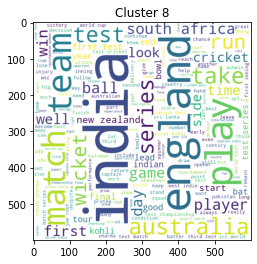

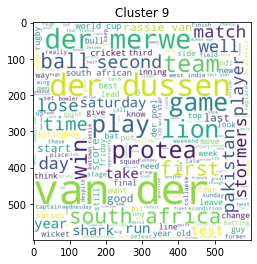

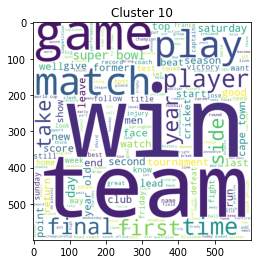

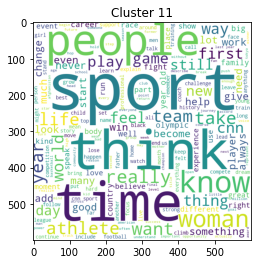

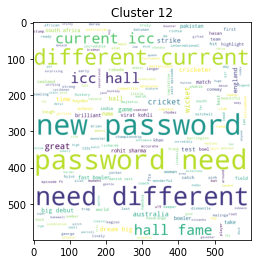

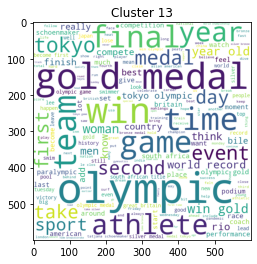

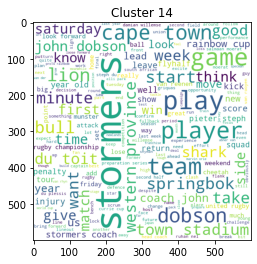

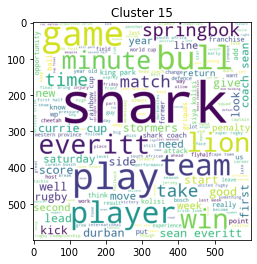

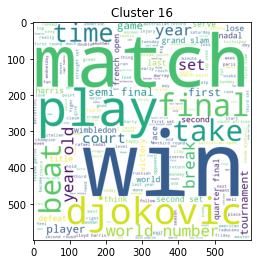

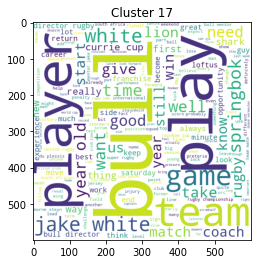

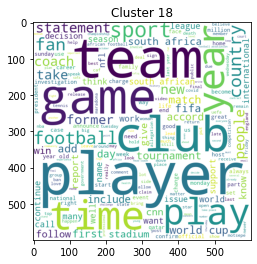

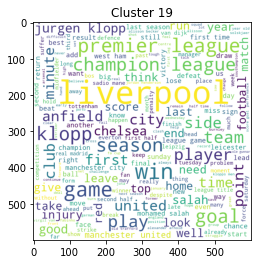

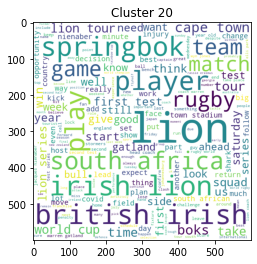

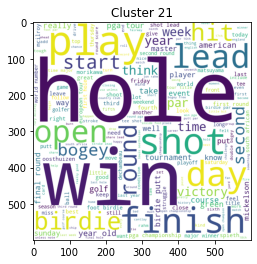

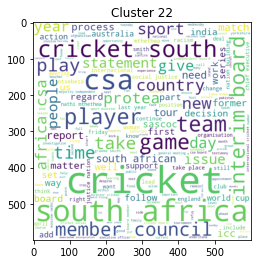

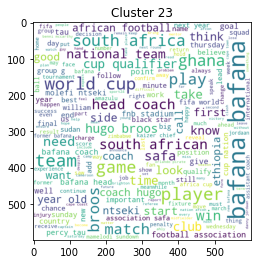

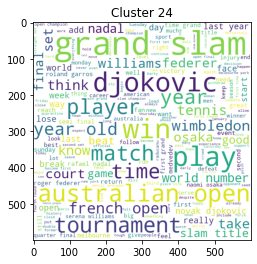

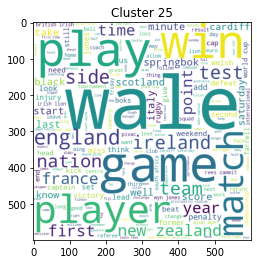

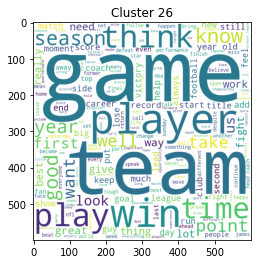

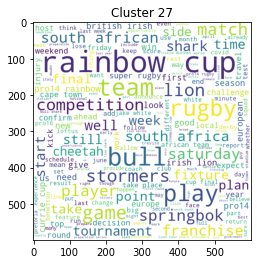

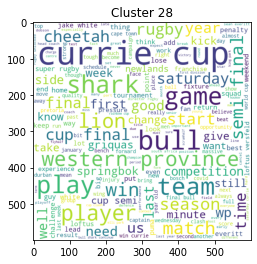

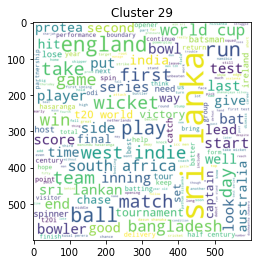

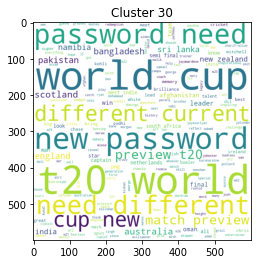

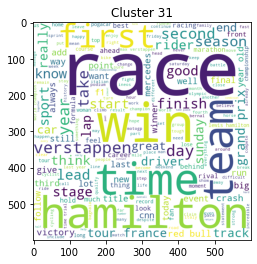

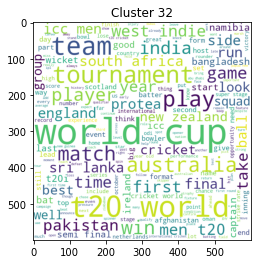

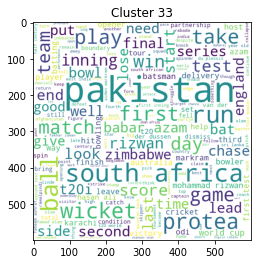

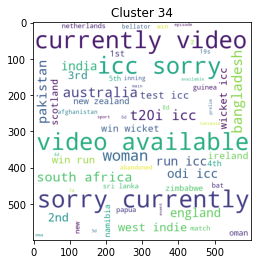

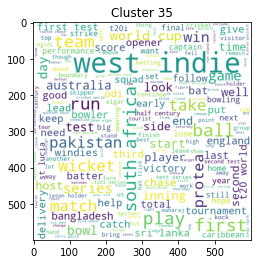

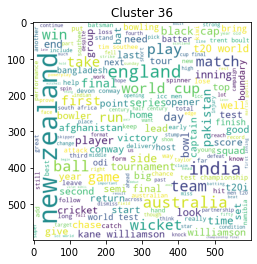

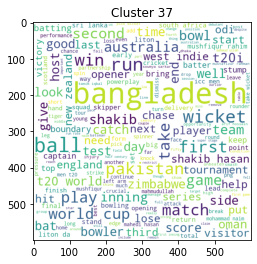

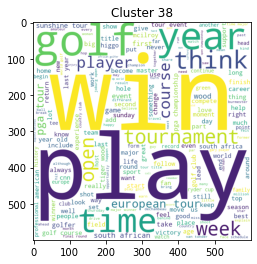

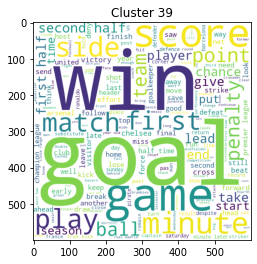

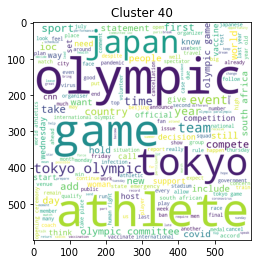

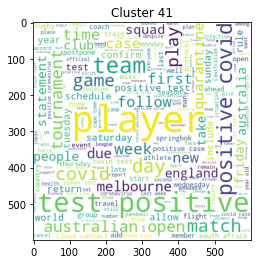

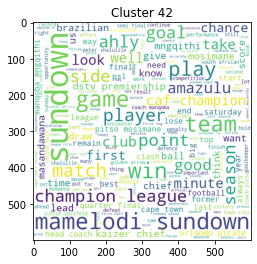

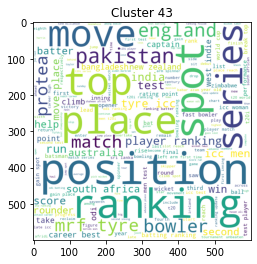

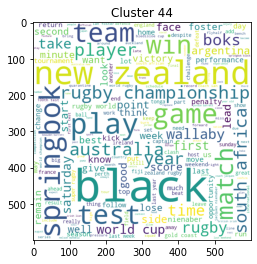

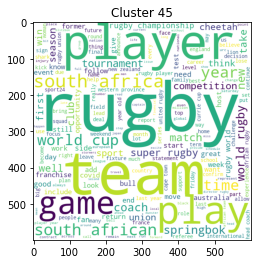

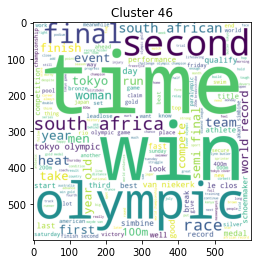

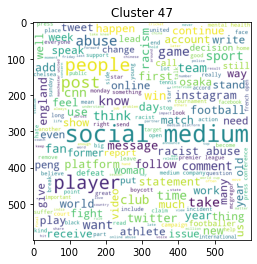

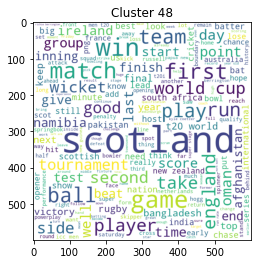

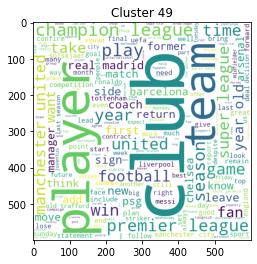

In [ ]:
# Create a list of clusters we got from K-means and sort it in ascending order
clusters = sports_data['Cluster_KM'].unique().tolist()
clusters.sort()

# Create a word-cloud instance
wc = WordCloud(background_color='white',height = 600,width = 600)
print('K-Means Clusters')

# Plot the Word Cloud for each cluster (words are from the cleaned text data)
plot_num = 1
plt.figure(figsize=(20,20))
km_cluster_list = sports_data["Cluster_KM"].unique().tolist()
km_cluster_list.sort()
for i in km_cluster_list:
    plt.imshow(wc.generate(' '.join(sports_data_cleaned[sports_data["Cluster_KM"]==i]['news_items']))) 
    plt.title("Cluster " + str(i))
    plot_num += 1
    plt.show()

Output Explanataion : In this I have formed the word cloud of all the clusters to shows all the features in them for a better visualization.

Now, I need to map these clusters with the connecting to the Sport Item, where this should be manually conducted. By analyzing the key features from the clusters, I need to match the Sport with it by considering all the features available. During this process, mapping the correct sport would be an advantage for our accuracy. 

For better visualization, I have created a word cloud visualization to sort the Sports items and their respective Key features.

Checking the Number of records at this point :  10244
Print Top 10 records from the list : 


news_items  Cluster_KM
0  Argentina defeats Colombia on penalties to rea...          39
1  Anthony Joshua wants Oleksandr Usyk rematch '1...          26
2  The Ashes: Australia beat England by 275 runs ...           2
3  Rejigged fixtures for Australia-India campaign...           8
4  Champions League quarterfinal draw: Bayern Mun...          19
5  'Sad' Spurs stunned as Trossard boosts Brighto...          39
6  No UEFA action for German 'keeper Neuer's rain...          18
7  India 365 vs England 205 & 135 | 4th Test | IC...          34
8  Sancho a victim of Solskjaer's struggle to str...          49
9  Injured Djokovic slams quarantine, suggests NB...          24

----------------------------------------------------------------------------------------------------


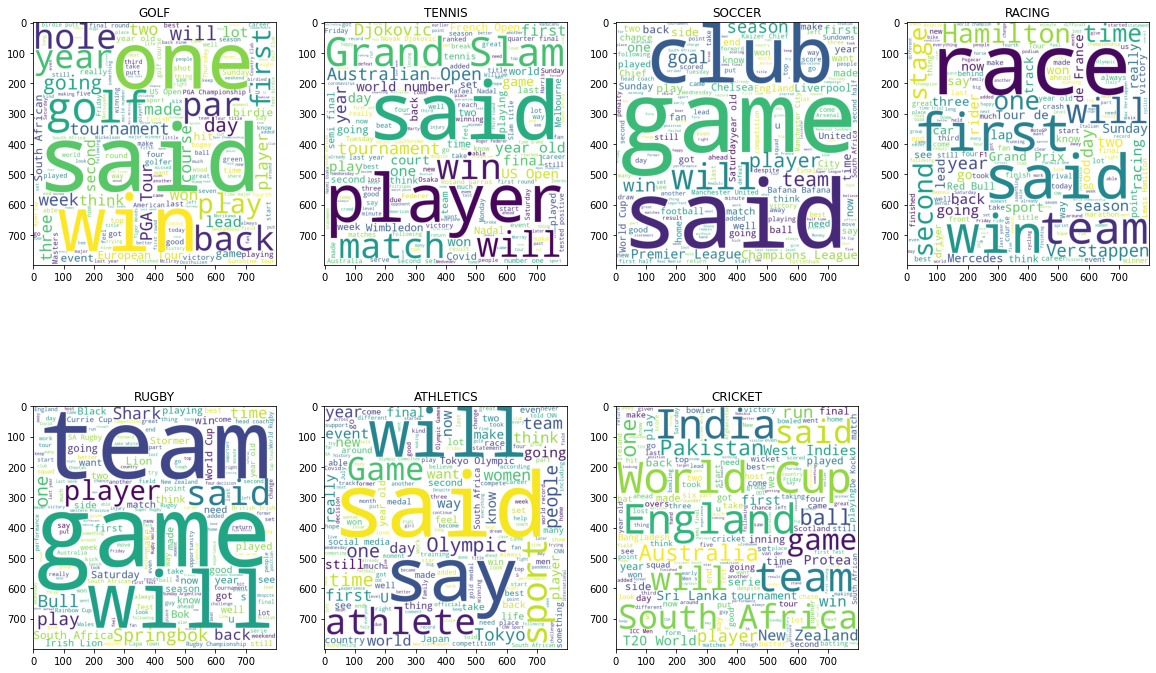

In [ ]:
# Cluster Mapping
cluster_map = [[0,'rugby'],[1,'cricket'],[2,'cricket'],[3,'rugby'],[4,'soccer'],[5,'soccer'],
               [6,'soccer'],[7,'cricket'],[8,'cricket'],[9,'cricket'],[10,'cricket'],
              [11,'athletics'],[12,'cricket'],[13,'athletics'],[14,'rugby'],[15,'rugby'],
               [16,'tennis'],[17,'rugby'],[18,'soccer'],[19,'soccer'],[20,'rugby'],
              [21,'golf'],[22,'cricket'],[23,'soccer'],[24,'tennis'],[25,'rugby'],
               [26,'rugby'],[27,'rugby'],[28,'rugby'],[29,'cricket'],[30,'cricket'],
              [31,'racing'],[32,'cricket'],[33,'cricket'],[34,'cricket'],[35,'cricket'],
               [36,'cricket'], [37,'cricket'], [38,'golf'], [39,'soccer'], [40,'athletics'], 
              [41,'tennis'], [42,'soccer'], [43,'cricket'],[44,'rugby'],[45,'rugby'],
               [46,'athletics'], [47,'athletics'],[48,'cricket'], [49,'soccer']]

# Map the clusters of k means and sports into aspects data fram object
cluster_aspects_df = pd.DataFrame(cluster_map,columns=['Cluster_KM', 'Sport'])
# get sport classes to specific object
t = cluster_aspects_df["Sport"].tolist()

# Create a flat list to capture the sport and cluster items
flat_list = set(t)
flat_list = list(flat_list)
flat_list

# Loop condition to iterate towards the cluster row aspect
for aspect in flat_list:
    cluster_aspects_df[aspect] = np.nan
    # Loop to iterate towards the cluster items
    for index, row in cluster_aspects_df.iterrows():
        if (aspect in row['Sport']):
            row[aspect]=1
            cluster_aspects_df.at[index, aspect] = 1
        else:
            cluster_aspects_df.at[index, aspect] = 0
    
    
#display(cluster_aspects_df)

# Create word cloud clusters
wc = WordCloud(background_color='white',height = 800,width = 800)

# Displat sport news items and belnging clusters
sports_data_with_clusters = pd.merge(sports_data, cluster_aspects_df, on="Cluster_KM")
print("Checking the Number of records at this point : ",len(sports_data))
print("Print Top 10 records from the list : ")
display(sports_data.head(10))

print("-"*100)
# Plot the Graph
plot_num = 1
plt.figure(figsize=(20,20))

# loop to loop through the flat list in order to identify the word cloud and suitable sport class
for aspect in flat_list:
    sub_df = sports_data_with_clusters[sports_data_with_clusters[aspect]==1]
    plt.subplot(3,4,plot_num)
    plt.imshow(wc.generate(' '.join(sub_df['news_items']))) 
    plt.title(aspect.upper())
    plot_num += 1

As you can see from the Ouput, there are 7 main sports items and the word cloud visualization has been shown. This 7 main clusters will be used to predict the test dataset, so that I'll be pushing the labbelled dataset to a CSV.

In [ ]:
# Create training labeled dataset for classification
training_data_labelled = sports_data_with_clusters[["news_items", "Sport"]] 
# Read item into reader object
training_data_labelled.to_csv("Training_labelled_dataset.csv", index=False, encoding="utf-8")

### Answer (g)

(g) Manually annotate the 300 randomly selected news items from the dataset into different sports. Check the accuracy of the model learned in (f) using this annotated sample as the ground truth.

Now, it's time to manually annotate the Testing Dataset which contains 300 records and this process takes some time to complete, as we should be analyzing the tweet_text and matching it with the correct sport. Later, I've done a null check to check whether I missed any column values without annotating.

Let's read the annotated CSV file and check the Dataset description.

In [ ]:
# Read the Manually annotated CSV file
test_data_annot = pd.read_csv("Testing_Annotated_Dataset.csv", header=None)

# Adding column name to the respective columns
test_data_annot.columns =['Tweet_Content', 'Annotated_Sport']

# Display the Total number of records in the Dataset
print("-"*100)
print("Total number of records in the Dataset :" , len(test_data_annot))

#Display the first 10 rows
print("-"*100)
print("Display records :")
display(test_data_annot)

# Handling missing values
# Identify any null values for each column
print("-"*100)
print("Print the number of null values for each column :")
test_data_annot.isnull().sum()

----------------------------------------------------------------------------------------------------
Total number of records in the Dataset : 300
----------------------------------------------------------------------------------------------------
Display records :


Tweet_Content Annotated_Sport
0    Injury scare as Djokovic plays through pain in...          tennis
1    ANALYSIS | Late Oz withdrawal will cut CSA's c...         cricket
2    Hogg leads experienced Scotland against Austra...         cricket
3    SA's Raven Klaasen captures Citi Open title in...           rugby
4    ICC Women's T20I | Player Rankings | ICC\nThe ...         cricket
..                                                 ...             ...
295  SA's Schoenmaker smashes another Olympic recor...       athletics
296  CT City coach concedes 'Pirates were better' a...          soccer
297  Cricket SA's Mzansi Super League again called ...         cricket
298  Impressive 1st half display secures Chiefs a w...          soccer
299  Sean Everitck-a-hoop about Sharks spring chick...           rugby

[300 rows x 2 columns]

----------------------------------------------------------------------------------------------------
Print the number of null values for each column :


Tweet_Content      0
Annotated_Sport    0
dtype: int64

Ouput Explanation : As you can notice there are 300 records in the dataset and some of the records for your display. Also, there are no empty values in the dataset as expected.

In [ ]:
# Transform the cleaned sentences in to features using our original vectorizer.
test_news_items_norm = normalize_corpus(test_data_annot['Tweet_Content'].tolist(), lemmatize=True, only_text_chars=True, tokenize=True)

test_tfidf_anon = vectorizer.transform(test_news_items_norm)

# Let's now cluster our test dataset using the same K-Means object we created 
test_clusters = km_obj.predict(np.asarray(test_tfidf_anon.todense())).tolist()

# Let's add the cluster number column to the dataset
test_data_annot = test_data_annot.assign(Cluster_Y=test_clusters)

# Let's merge the cluster mapping we created in the former question into our dataset
cluster_aspects_df_1 = cluster_aspects_df[["Cluster_KM", "Sport"]] 

test_data_annot = pd.merge(test_data_annot,cluster_aspects_df_1,right_on="Cluster_KM",left_on="Cluster_Y")

# Display the Results along with the prediction results
display(test_data_annot)

# Push the results to a CSV
test_data_annot.to_csv("Testing_Prediction_Results.csv", index=False)

Tweet_Content Annotated_Sport  \
0    Injury scare as Djokovic plays through pain in...          tennis   
1    Australian Open boss 'confident' event will go...          tennis   
2    Iga Swiatek serene as questions linger over Fr...          tennis   
3    'Suffering' Nadal's Aussie Open in doubt with ...          tennis   
4    World No 1 Barty to end year-long absence in A...          tennis   
..                                                 ...             ...   
295  When Lauren Price met the Duke of Cambridge\nT...       athletics   
296  Thriston Lawrence leads Joburg Open as Covid-1...            golf   
297  American Finau wins playoff to capture maratho...            golf   
298  Oosthuizen not intimidated by Torrey Pines lay...            golf   
299  New Zealand aim to avoid whitewash against a c...         cricket   

     Cluster_Y  Cluster_KM      Sport  
0           24          24     tennis  
1           24          24     tennis  
2           24          24     tennis  
3           24          24     tennis  
4           24          24     tennis  
..         ...         ...        ...  
295         13          13  athletics  
296         21          21       golf  
297         21          21       golf  
298         21          21       golf  
299         36          36    cricket  

[300 rows x 5 columns]

In [ ]:
# Created testting labbeled data using the annotated data
testing_data_labelled = test_data_annot[["Tweet_Content", "Sport"]]
# Add labbeled items to reader
testing_data_labelled.to_csv("Testing_labelled_dataset.csv", index=False)

Describe how the ground truth was compared with model...

The Ground Truth is decided based on the annotated sample records and we need to perform an external validation to check the Model's accuracy. I've used the "Jaccard Coefficient" as a metric to see the performance of the K-Mean Model.

This is also known as the Jaccard similarity coefficient, is a statistic used for gauging the similarity and diversity of sample sets.It compares members for two sets to see which members are shared and which are distinct. It's a measure of similarity for the two sets of data, with a range from 0% to 100%. 

The score is basically calculated between the Predicted labels vs the Actual labels.The higher the percentage, the more similar the two populations.

In [ ]:
# Converting to binary form
y_true = MultiLabelBinarizer().fit_transform(test_data_annot["Annotated_Sport"])
y_pred = MultiLabelBinarizer().fit_transform(test_data_annot["Sport"])

# Output the Jaccard Score
# Equation = jaccard_score(y_true, y_pred, average="micro")
jaccard_output = jaccard_score(y_true, y_pred, average='micro')
print("Jaccard Coefficient:",jaccard_output)

Jaccard Coefficient: 0.7848712446351931


What is the estimated accuracy of the model...

The Jaccard score is 0.7848 which is a good score and this indicates 78% of clustering model accuracy.

### Answer (h)

(h) Assume that the categorization you arrived at in (f) is close enough to the ‘ground truth’ and use the categories learnt as their labels. Take necessary action to remedy any imbalance in the data you may have. Use 3 different non-deep learning algorithms from scikit-learn that would help you classify this data, giving reasons for the choice of each such algorithm. Comment on the performance of each of the classifiers.

Provide the reasoning for the 3 algorithms used...

I've used three different classifiers from the scikit-library and below are the reason behind choosing them.

1- Support Vector Machine (SVM) - A support vector machine is highly preferred by many as it produces significant accuracy with less computation power. Support Vector Machine, abbreviated as SVM can be used for both regression and classification tasks. But, it is widely used in classification objectives. The objective of the support vector machine algorithm is to find a hyperplane in N-dimensional space(N the number of features) that distinctly classifies the data points. This can populate the most accurate prediction when if it's a very complex dataset. Since the Text classifier is more complex, I thought of using this to get a better prediction.

2- Multinomial Naive Bayes - The Multinomial Naive Bayes algorithm is a Bayesian learning approach popular in Natural Language Processing (NLP). The program guesses the tag of a text, such as an email or a newspaper story, using the Bayes theorem. It calculates each tag's likelihood for a given sample and outputs the tag with the greatest chance. This can produce good accuracy even if there are fewer data. using the TF-IDF features can produce how frequent words appear in a specific document and how inversely frequent the tag appears in the document. It is simple to implement because all you have to do is calculate probability. This approach works with both continuous and discrete data. It's straightforward and can be used to forecast real-time applications. It's very scalable and can handle enormous datasets with ease.


3- Logistic Regression - The multinomial logistic regression model, is a statistical model used for text classifications. Basically, Logistic Regression is used when the dependent variable(target) is categorical. For example, To predict whether an email is spam (1) or (0). This can predict the dependent variable using the independent variable (continuous or nominal). So this scenario I will be predicting what Sports category will be categorized into so that a multinomial logistic regression would produce a good prediction.

Let's read the Training and Testing labelled data which we extracted from the above section

In [ ]:
# Read both the Train and Testing labelled Dataset
training_data_labelled = pd.read_csv("Training_labelled_dataset.csv")
print("Training labelled Dataset : ")
display(training_data_labelled)

testing_data_labelled = pd.read_csv("Testing_labelled_dataset.csv")
print("Testing labelled Dataset : ")
display(testing_data_labelled)

Training labelled Dataset : 


news_items    Sport
0      Argentina defeats Colombia on penalties to rea...   soccer
1      'Sad' Spurs stunned as Trossard boosts Brighto...   soccer
2      Lukaku injury mars Chelsea's rout of Malmo\nCh...   soccer
3      Bristol City edge past Pompey in FA Cup\nLast ...   soccer
4      Pumas narrowly hold off Griquas to claim 2nd C...   soccer
...                                                  ...      ...
10239  EXCLUSIVE: Former Scotland flanker David Dento...  cricket
10240  Pakistan face Scotland with eye on fifth strai...  cricket
10241  England duo Mount, Chilwell isolating after Gi...  cricket
10242  Scotland, Zimbabwe T20I series heads to an exc...  cricket
10243  India smash Scotland by eight wickets to boost...  cricket

[10244 rows x 2 columns]

Testing labelled Dataset : 


Tweet_Content      Sport
0    Injury scare as Djokovic plays through pain in...     tennis
1    Australian Open boss 'confident' event will go...     tennis
2    Iga Swiatek serene as questions linger over Fr...     tennis
3    'Suffering' Nadal's Aussie Open in doubt with ...     tennis
4    World No 1 Barty to end year-long absence in A...     tennis
..                                                 ...        ...
295  When Lauren Price met the Duke of Cambridge\nT...  athletics
296  Thriston Lawrence leads Joburg Open as Covid-1...       golf
297  American Finau wins playoff to capture maratho...       golf
298  Oosthuizen not intimidated by Torrey Pines lay...       golf
299  New Zealand aim to avoid whitewash against a c...    cricket

[300 rows x 2 columns]

Normalize the data for classification

In [ ]:
# Extract the corpus and labels from Test and Traing Dataset
training_corpus = training_data_labelled['news_items'].tolist()
training_labels = training_data_labelled['Sport'].tolist()

testing_corpus = testing_data_labelled['Tweet_Content'].tolist()
testing_labels = testing_data_labelled['Sport'].tolist()

# Normalize the corpus using normalize_corpus method
training_nomalized_corpus = normalize_corpus(training_corpus, lemmatize=True, only_text_chars=True, tokenize=True)

testing_nomalized_corpus = normalize_corpus(testing_corpus, lemmatize=True, only_text_chars=True, tokenize=True)

As mentioned above i'll be using the TD-IDF vectorizer to get the training features and testing feaatures, as we need this for the text classifications

In [ ]:
# Function that returns the token back
def do_nothing(tokens):
    return tokens

# Initialze the tfidf vectorize object
tfidf_vectorizer = TfidfVectorizer(min_df=0.03, max_df=0.5, ngram_range=(1,3),
                                   tokenizer=do_nothing,
                                   preprocessor=None,
                                   lowercase=False)

# Use tf-idf vectorize to fit and transform both train and test labbeled data.
# This is done to identify its features
tfidf_train_features = tfidf_vectorizer.fit_transform(training_nomalized_corpus).astype(float)

tfidf_test_features = tfidf_vectorizer.transform(testing_nomalized_corpus)

These are the two methods to print the 4 main common metrics in the Confusion Metrix and to evaluate the model.
1- Recall - From all the positive classes, how many we predicted correctly.

2- Precision - From all the classes we have predicted as positive, how many are actually positive.

3- Accuracy - From all the classes (positive and negative), how many of them we have predicted correctly.

4- F1 score - It is difficult to compare two models with low precision and high recall or vice versa. So to make them comparable, we use F-Score. F-score helps to measure Recall and Precision at the same time.

In [ ]:
# Function to calculate 4 common metrics
def get_metrics(true_labels, predicted_labels):
    print('Recall (Sensitivity)   :', metrics.recall_score(true_labels, predicted_labels, average='weighted'))
    print('Precision              :', metrics.precision_score(true_labels, predicted_labels, average='weighted'))
    print('Accuracy               :', metrics.accuracy_score(true_labels, predicted_labels))
    print('F1 Score               :', metrics.f1_score(true_labels, predicted_labels,average='weighted'))
    print(confusion_matrix(true_labels, predicted_labels))
    
# Wrapper function to call to train, predict and evaluate performance
def train_predict_evaluate_model(classifier, train_features, train_labels, test_features, test_labels):  
    classifier.fit(train_features, train_labels)
    predictions = classifier.predict(test_features)
    get_metrics(true_labels=test_labels, predicted_labels=predictions)
    return predictions  

Below is the code snippet passignthe TD-IDF test and train features respectively to each model and print the evaluation metrices accordingly.

Support Vector Machine
----------------------------------------------------------


In [ ]:
# Support Vector Machine with tfidf features
support_vector_machine = SGDClassifier(loss='hinge', max_iter=1000)
print("-------------- Support Vector Machine ------------------")
svm_tfidf_predictions = train_predict_evaluate_model(classifier=support_vector_machine,
                                                       train_features=tfidf_train_features,
                                                       train_labels=training_labels,
                                                       test_features=tfidf_test_features,
                                                       test_labels=testing_labels)
# We can then understand Recall, Precision, Specificity, Accuracy, and, most importantly, the AUC-ROC Curve.

-------------- Support Vector Machine ------------------
Recall (Sensitivity)   : 0.89
Precision              : 0.8971980676328504
Accuracy               : 0.89
F1 Score               : 0.8907654272515053
[[18  1  0  0  1  3  0]
 [ 0 92  2  0  3  4  0]
 [ 0  0  8  0  0  0  0]
 [ 0  0  0  4  0  0  0]
 [ 0  4  2  0 62  6  0]
 [ 0  3  0  0  3 62  0]
 [ 0  0  0  1  0  0 21]]


Multinomial Naive Bayes
----------------------------------------------------------


In [ ]:
# Multinomial Naive Bayes with tfidf features
multinomial = MultinomialNB()
print("--------------- Multinomial Naive Bayes ---------------")
mnb_tfidf_predictions = train_predict_evaluate_model(classifier=multinomial,
                                                       train_features=tfidf_train_features,
                                                       train_labels=training_labels,
                                                        test_features=tfidf_test_features,
                                                       test_labels=testing_labels)



--------------- Multinomial Naive Bayes ---------------
Recall (Sensitivity)   : 0.8533333333333334
Precision              : 0.8666389301953543
Accuracy               : 0.8533333333333334
F1 Score               : 0.8545827973196394
[[19  1  0  0  0  3  0]
 [ 0 82  5  0  8  6  0]
 [ 0  0  8  0  0  0  0]
 [ 0  0  0  4  0  0  0]
 [ 0  5  0  0 58 11  0]
 [ 0  1  0  0  2 64  1]
 [ 0  0  0  0  1  0 21]]


Logistic Regression
----------------------------------------------------------


In [ ]:
# Logistic Regression with tfidf features
logistic = LogisticRegression(random_state=0)
print("-------------- Logistic Regression -----------------------")
log_tfidf_predictions = train_predict_evaluate_model(classifier=logistic,
                                                       train_features=tfidf_train_features,
                                                       train_labels=training_labels,
                                                       test_features=tfidf_test_features,
                                                       test_labels=testing_labels)

NameError: ignored

Output Explanataion : As you can notice all three models are producing good results - <br>
F1 Score - SVM                        : 0.890 <br>
F1 Score - Multinomial Naive Bayes    : 0.854 <br>
F1 Score - LogisticRegression         : 0.883 <br>

Also, we can notice each label has equal distribution of correct predictions. To check each classes has distributed correctly, I've printed to see if any imbalance is there.

In [ ]:
# Class distribution
# define label distribution based on sport and the number of occurences
class_distribution = training_data_labelled.groupby(['Sport'])['Sport'].count()
# Display the label distribution
print(class_distribution)

From the output above, we can notice that the classes are imbalanced. So in order to fix this imbalance, we can either use Over sampling or undersampling. So the process of resampling can bring the classes to equal distribution levels. So by analyzing the number of records in the Dataset, I've decided to do the oversampling (to prevent loss of data by undersampling). In that case, we have two methods to achieve it, one is Random sampling and the other one is Synthetic Minority Oversampling TEchnique (SMOTE). The SMOTE is considered one of the most powerful solutions for imbalanced data.SMOTE can be seen as an advanced version of oversampling, or as a specific algorithm for data augmentation. The advantage of SMOTE is that you are not generating duplicates, but rather creating synthetic data points that are slightly different from the original data points.

In [ ]:
# SMOTE - To balance the classes
os = SMOTE(random_state=0)

data_X, data_Y = os.fit_resample(tfidf_train_features, training_labels)

# Print the Counter
print("Print the Counter : ", Counter(data_Y))

Output shows that 7 classes are perfectly balanced.

After balancing the imbalanced classes, I have ran the three models again to see if any changes in teh accuracy.

Support Vector Machine
----------------------------------------------------------


In [ ]:
# Support Vector Machine with tfidf features
print("-------------- Support Vector Machine ------------------")
svm_tfidf_predictions = train_predict_evaluate_model(classifier=support_vector_machine,
                                                       train_features=data_X,
                                                       train_labels=data_Y,
                                                       test_features=tfidf_test_features,
                                                       test_labels=testing_labels)


-------------- Support Vector Machine ------------------
Recall (Sensitivity)   : 0.87
Precision              : 0.8808846754567579
Accuracy               : 0.87
F1 Score               : 0.8719683491112061
[[19  1  0  0  1  2  0]
 [ 0 87  4  0  4  6  0]
 [ 0  0  8  0  0  0  0]
 [ 0  0  0  4  0  0  0]
 [ 0  4  2  0 61  7  0]
 [ 0  3  0  0  3 61  1]
 [ 0  0  0  1  0  0 21]]


Multinomial Naive Bayes
----------------------------------------------------------


In [ ]:
# Multinomial Naive Bayes with tfidf features
print("--------------- Multinomial Naive Bayes ---------------")
mnb_tfidf_predictions = train_predict_evaluate_model(classifier=multinomial,
                                                       train_features=data_X,
                                                       train_labels=data_Y,
                                                       test_features=tfidf_test_features,
                                                       test_labels=testing_labels)

--------------- Multinomial Naive Bayes ---------------
Recall (Sensitivity)   : 0.8266666666666667
Precision              : 0.8443356987954004
Accuracy               : 0.8266666666666667
F1 Score               : 0.8287703908903933
[[19  0  0  1  0  3  0]
 [ 2 79  5  1  8  5  1]
 [ 0  0  8  0  0  0  0]
 [ 0  0  0  4  0  0  0]
 [ 1  5  2  1 56  9  0]
 [ 3  0  0  0  2 61  2]
 [ 0  0  0  0  1  0 21]]


Logistic Regression
----------------------------------------------------------


In [ ]:
# Logistic Regression with tfidf features
print("-------------- Logistic Regression -----------------------")
log_tfidf_predictions = train_predict_evaluate_model(classifier=logistic,
                                                       train_features=data_X,
                                                       train_labels=data_Y,
                                                       test_features=tfidf_test_features,
                                                       test_labels=testing_labels)

-------------- Logistic Regression -----------------------
Recall (Sensitivity)   : 0.8833333333333333
Precision              : 0.8885261859053556
Accuracy               : 0.8833333333333333
F1 Score               : 0.8836373559825271
[[18  1  0  0  1  3  0]
 [ 1 88  2  0  4  6  0]
 [ 0  0  8  0  0  0  0]
 [ 0  0  0  4  0  0  0]
 [ 0  5  0  0 63  6  0]
 [ 0  2  0  0  3 63  0]
 [ 0  0  0  1  0  0 21]]


C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Comment on the performance of the 3 algorithms...

F1 Score - SVM  0.871 <br>
F1 Score - Multinomial Naive Bayes  0.828 <br>
F1 Score - LogisticRegression   0.883 <br>

The accuracy is almost same comparing before and after Sampling. This shows the Class imbalance has not provide a huge effect on the accuracy of the model.

### Answer (i)

(i) Use the same assumptions as (h) and explore 2 deep learning architectures2 to try to improve the sports data classification results. Comment on the performance of the deep learning models.

Explain the 2 deep learning algorithms used to perform the classification :

1- 1 Dimensional Convolutional Neural Network in Keras - The 1D CNN is one of the best choices in the field of Text classifications and this is perfect for time series data.

2- Long Short-Term Memory (LSTM) - This is one type of Recurrent Neural Network. This especially stores the relationships among the words and uses them for classification.

Read the labelled Test and Train datasets.

In [ ]:
# Read CSV files and diplay the data
training_data_labelled = pd.read_csv("Training_labelled_dataset.csv")
display(training_data_labelled)

testing_data_labelled = pd.read_csv("Testing_labelled_dataset.csv")
display(testing_data_labelled)

news_items    Sport
0      Argentina defeats Colombia on penalties to rea...   soccer
1      'Sad' Spurs stunned as Trossard boosts Brighto...   soccer
2      Lukaku injury mars Chelsea's rout of Malmo\nCh...   soccer
3      Bristol City edge past Pompey in FA Cup\nLast ...   soccer
4      Pumas narrowly hold off Griquas to claim 2nd C...   soccer
...                                                  ...      ...
10239  EXCLUSIVE: Former Scotland flanker David Dento...  cricket
10240  Pakistan face Scotland with eye on fifth strai...  cricket
10241  England duo Mount, Chilwell isolating after Gi...  cricket
10242  Scotland, Zimbabwe T20I series heads to an exc...  cricket
10243  India smash Scotland by eight wickets to boost...  cricket

[10244 rows x 2 columns]

Tweet_Content      Sport
0    Injury scare as Djokovic plays through pain in...     tennis
1    Australian Open boss 'confident' event will go...     tennis
2    Iga Swiatek serene as questions linger over Fr...     tennis
3    'Suffering' Nadal's Aussie Open in doubt with ...     tennis
4    World No 1 Barty to end year-long absence in A...     tennis
..                                                 ...        ...
295  When Lauren Price met the Duke of Cambridge\nT...  athletics
296  Thriston Lawrence leads Joburg Open as Covid-1...       golf
297  American Finau wins playoff to capture maratho...       golf
298  Oosthuizen not intimidated by Torrey Pines lay...       golf
299  New Zealand aim to avoid whitewash against a c...    cricket

[300 rows x 2 columns]

Read the labelled Test and Train datasets.

In [ ]:
# Read CSV files
training_data_labelled = pd.read_csv("Training_labelled_dataset.csv")
display(training_data_labelled)

testing_data_labelled = pd.read_csv("Testing_labelled_dataset.csv")
display(testing_data_labelled)

Split the data to Train and Testing labels, by setting the tokenize param as False.

In [ ]:
train_corpus = training_data_labelled['news_items'].tolist()
train_labels = training_data_labelled['Sport'].tolist()

test_corpus = testing_data_labelled['Tweet_Content'].tolist()
test_labels = testing_data_labelled['Sport'].tolist()

# Lemmatize and normalize both tweet train and trained normalized corpus
train_corpus_norm = normalize_corpus(train_corpus, lemmatize=True, only_text_chars=True, tokenize=False)

test_corpus_norm = normalize_corpus(test_corpus, lemmatize=True, only_text_chars=True, tokenize=False)

1 D Convolutional Neural Network
----------------------------------------------------------


Let's tokenize using KERAS and then convert the texts to a sequence to pad those sequence using KERAS functions.

In [ ]:
# Let's use the KERAS tokenizer for a change 
# Kera tokenizer was used to fit the tweet train corpus normalized content
tokenizer = Tokenizer(num_words=4000)
# The tokenizer object was then fit on the texts
tokenizer.fit_on_texts(training_nomalized_corpus)

# Both normalized train and test data are tokenized using the keras tokenizer and stored in objects
train_corpus_norm_tts = tokenizer.texts_to_sequences(training_nomalized_corpus)
test_corpus_norm_tts = tokenizer.texts_to_sequences(testing_nomalized_corpus)

vocab_size = len(tokenizer.word_index) + 1

# Include a maxlen (this can be tweaked)
maxlen = 200

# Keras normalize ensures that all the sequences in the list have the same length
# Each pad has the same lenght as the longest sequence
train_corpus_norm_pad = pad_sequences(train_corpus_norm_tts, padding='post', maxlen=maxlen)
test_corpus_norm_pad = pad_sequences(test_corpus_norm_tts, padding='post', maxlen=maxlen)

Keras Neural Network expect the number of labels in the Training and the Testing dataset to be same. So that the labels neds to be mapped with integers as keras expects in vectors.

The OneHotEncoder to transfer them into vectors.

In [ ]:
# Creating integer encodes for both train and test dataset
integer_encoded_train = []
integer_encoded_test = []

# Labels with uniqe integers
d = {'soccer': 0, 'rugby': 1, 'cricket': 2, 'tennis': 3, 'athletics': 4, 'golf': 5, 'racing': 6}

# Encode both the Train and Test dataset
integer_encoded_test = [d[k] for k in testing_labels]
integer_encoded_train = [d[k] for k in training_labels]

# Using one hot encoder object type to convert string to integer
onehot_encoder = OneHotEncoder(sparse=False)

# Encoding test and train data
integer_encoded_test = np.asarray(integer_encoded_test)
integer_encoded_train = np.asarray(integer_encoded_train)

integer_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)
onehot_encoded_test = onehot_encoder.fit_transform(integer_encoded_test)

integer_encoded_train = integer_encoded_train.reshape(len(integer_encoded_train), 1)
onehot_encoded_train = onehot_encoder.fit_transform(integer_encoded_train)

# Display matric result from both test and train encoded data
print(onehot_encoded_test)
print(onehot_encoded_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In the below code, I have created the 1D CNN using CNN and Dense activation layer. A callback is written to add a checkpoint with the Best accuracy after it runs through the number of epochs. I have set the Epochs to 20, so that it loops through the training data for 20 rounds. 

Later this will print the predicted and evaluate the Test data and evaluation metrics accordingly.

In [ ]:
# Model building
filter_length = 300

# Create the model

# for overfitting alter dropout or add more dropouts to other layers
# regularization
# preprocessing
# change dataset

# Identify maximu lenght required
maxlen = 200
# Maximu word required
max_words = 4000
# Idenfitied number of classes
num_classes = 7

# Arranging the keras model in a sequential order
model = Sequential()

# Turns positive intgers into dense vectors of fixed size
model.add(Embedding(max_words, 20, input_length=maxlen))
# Include dropout frequence
model.add(Dropout(0.1))
# Use convolutional 1D layer
model.add(Conv1D(filter_length, 3, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPool1D())
# Use dense model to identify the classes
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy'])
model.summary()


callbacks = [ReduceLROnPlateau(), ModelCheckpoint(filepath='model-conv1d.h5', save_best_only=True)]

# re-validatin gthe model
history = model.fit(train_corpus_norm_pad, onehot_encoded_train,class_weight=None, epochs=20,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=callbacks)

# Print out accuracy metrics 
# Load keras cnn kodel back
cnn_model = keras.models.load_model('model-conv1d.h5')
metrics = cnn_model.evaluate(test_corpus_norm_pad, onehot_encoded_test)

print("{}: {}".format(model.metrics_names[0], metrics[0]))
print("{}: {}".format(model.metrics_names[1], metrics[1]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 20)           80000     
                                                                 
 dropout_38 (Dropout)        (None, 200, 20)           0         
                                                                 
 conv1d (Conv1D)             (None, 198, 300)          18300     
                                                                 
 global_max_pooling1d (Globa  (None, 300)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 7)                 2107      
                                                                 
 activation (Activation)     (None, 7)                 0         
                                                        

Output Explanataion : The Categorical Accuracy is 74% , which is comparitive lower than the other models.

In this part I've created the LSTM using the Input layer, Embedding layer , LSTM layer, Dense layer and Activation layer. I have set the Epochs to 20, so that it loops through the training data for 20 rounds. 

LSTM
----------------------------------------------------------


In [ ]:
# Arranging the Keras mode in a sequential order using lstm as the second model for predictions
lstm_model = Sequential()

lstm_model.add(Input(name='inputs',shape=[maxlen]))
# Add positive integers into dense vectors of fixed size
lstm_model.add(Embedding(max_words, 20, input_length=maxlen))
# Use lstm models
lstm_model.add(LSTM(128))
# Use dense model to identify the classes
lstm_model.add(Dense(64, activation='relu'))
# Use dropout frquency
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(7, activation='softmax'))

# fit lstm model using the one hot encoded datafeatures
lstm_model.compile( loss='categorical_crossentropy',optimizer=Adam(lr=0.001, decay=1e-6),metrics=['accuracy'] )

# Fit lstm model using the one hot encoded data features
lstm_model.fit(train_corpus_norm_pad,onehot_encoded_train,epochs=20,validation_data=(test_corpus_norm_pad, onehot_encoded_test))

# Identify the loss and test accuracy from the lstm model
test_loss, test_acc = lstm_model.evaluate(test_corpus_norm_pad, onehot_encoded_test)

# Display loss and accuracy
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

Epoch 1/20


C:\Users\LENOVO\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


321/321 [==============================] - 151s 445ms/step - loss: 1.4999 - accuracy: 0.3366 - val_loss: 1.4471 - val_accuracy: 0.4233
Epoch 2/20
321/321 [==============================] - 141s 440ms/step - loss: 1.3803 - accuracy: 0.3959 - val_loss: 1.6065 - val_accuracy: 0.3567
Epoch 3/20
321/321 [==============================] - 142s 442ms/step - loss: 1.2652 - accuracy: 0.4490 - val_loss: 1.2088 - val_accuracy: 0.5200
Epoch 4/20
321/321 [==============================] - 140s 437ms/step - loss: 1.3356 - accuracy: 0.4346 - val_loss: 1.5358 - val_accuracy: 0.3467
Epoch 5/20
321/321 [==============================] - 141s 439ms/step - loss: 1.4180 - accuracy: 0.4175 - val_loss: 1.3931 - val_accuracy: 0.4400
Epoch 6/20
321/321 [==============================] - 142s 442ms/step - loss: 1.2100 - accuracy: 0.4999 - val_loss: 1.2285 - val_accuracy: 0.4867
Epoch 7/20
321/321 [==============================] - 139s 434ms/step - loss: 1.1764 - accuracy: 0.5168 - val_loss: 1.2605 - val_accura

Comment on their performance in comparison to part (h)...

The 1D CNN has produced the Accuracy of 0.746 and the loss of 0.193 and at the same time LSTM has produced the Accuracy of 0.736 and the loss of 0.766.

The training Dataset is considerably lower in size compared to the real-world example. So when we compare the accuracy with the non-deep learning models which are slightly the same as it plays a major role considering the volume of the dataset as well. By considering the numbers we can conclude that the overall accuracy of the Deep learning models is lesser than the Non-deep learning models.

### Answer (j)

Describe how overfitting would be detected and what could be done...

While the model is printed, we can collect the diagnostic information that it prints to check whether the deep learning algorithms are overfitted. 

For example, let's take one epoch from the previous execution which is :
289/289 [==============================] - 30s 102ms/step - loss: 0.0055 - categorical_accuracy: 0.9991 - val_loss: 0.5849 - val_categorical_accuracy: 0.7102 - 

and the categorical_accuracy: 0.7699999809265137

we can notice there's a mismatch in both categorical accuracy and the validated categorical accuracy. If there's a difference or the if the actual accuracy is more than the validation accuracy, then it states it's overfitted. This can lead to a mismatch when we want this model to work with any other new dataset other than this.

There are some solutions to resolve this issue:
1- Data Augmentation - A larger dataset would reduce the overfitting. In case we do not have much data, we can apply augmentation to artificially increase the size of the dataset.

2- L1/L2 regularization (Learning algorithm) - In regularization, we can add a penalty term on the cost function to push the estimated coefficients to zero.L2 regularization allows weights to decay towards zero but not to zero, while L1 regularization allows weights to decay to zero.

3- Remove layers/ Number of units per layer (Model) - over complex model can cause overfit, therefore we can remove the layers from the model and reduce the size of our model. At the same time, the model should sufficiently balance the underfit and overfit for the task.

4- Dropout (Model) - Using dropout we can reduce the interdependent learning among units, which leads to overfitting. We need more epochs for the model to converge.

5- Hold-out - Splitting the data to a ratio of 80% for training and 20% for testing. So this indicates a good generalization. According to our scenario, I've split 300 records for Testing and 10544 for Training, which is considered insufficient. At least by considering the ratio, I should have allocated at least around 2000 records for the testing.



### Answer (k)

Explain the transfer learning model tried...

Out of the two main architectures BERT and ELMo in the Transfer learning, I've used the BERT Architecture for the implementation. As it is considered to be one of the most popular architectures with many resources for developers to learn. I've used the 'Bert-base-cased' Model available in the open source platform called hugging face <https://huggingface.co/>. Under the Text classification process, there are many pre-trained models available that come under the BERT architecture. This is actually pre-trained for two main reasons one of them is the masked language model and the other one is sentence prediction. Because of this, I considered using the BERT architecture, as it could be a good fit to take out the whole corpus and predict something.

BERT - Bidirectional Encoder Representations from Transformers
----------------------------------------------------------


Here i've defined the labels as class name and have loaded the CSV files by changing the Header to text and label (which is the only way huggingface recognize the datasets).

In [ ]:
# Define the Classes
class_names = ["soccer", "rugby", "cricket", "tennis", "athletics", "golf", "racing"]

# Get the Sport features using the column names text and label
sport_features = Features({'text': Value('string'), 'label': ClassLabel(names=class_names)})

# Load the Training and Testing Dataset
dataset = load_dataset('csv', data_files={'train': 'C:\\Users\\LENOVO\\Desktop\\MASTERS\\TEXT ANALYTICS\\COURSE WORK\\Jupyter Notebooks\\Training_labelled_dataset1.csv', 'test': 'C:\\Users\\LENOVO\\Desktop\\MASTERS\\TEXT ANALYTICS\\COURSE WORK\\Jupyter Notebooks\\Testing_labelled_dataset1.csv'}, features=sport_features)
dataset

Using custom data configuration default-1dd6ac86fcf756d0
Reusing dataset csv (C:\Users\LENOVO\.cache\huggingface\datasets\csv\default-1dd6ac86fcf756d0\0.0.0\51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10244
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 300
    })
})

Tokenizing the dataset for the model.

In [ ]:
# Tokenize the dataset using the AutoTokenize fucntion - given by huggingface
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Include the tokenize object to the dataset object
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset

Parameter 'function'=<function tokenize_function at 0x0000022226A01310> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/11 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10244
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 300
    })
})

Create a tensorflow dataset using the Traning and the Testing datasets.

In [ ]:
# Create tensorflow dataset
data_collator = DefaultDataCollator(return_tensors="tf")

# Training dataset
tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

#Testing dataset
tf_validation_dataset = tokenized_dataset["test"].to_tf_dataset(columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

Use the 'bert-base-cased' pre-trained model to our datasets.

In [ ]:
# Use the pre-trained model
# It will load and download the model
#we load the model with TFAutoModelForSequenceClassification. One crucial aspect in loading transformers 
#models is choosing the right Class. Since we are using a pre-trained model for Sentiment Analysis we will use the 
#loader for TensorFlow (that’s why we import the TFAutoModel class) for Sequence Classification. If you are unsure 
# what Class to load just check the model card or “Use in transformers” info on Huggingface model page for which class to use.
model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)

model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
Total params: 108,314,117
Trainable params: 108,314,117
Non-trainable params: 0
_________________________________________________________________


Setting the model compilation params like optimizer , loss and metrics and I have used Sparse categorical as predictions.

In [ ]:
# Compile the model
# Compile stage w egive the optimizer, loss and metrics took it from the documentation...
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

Fitting the training tensorflow dataset with 3 epochs. So for this execution I have used the google colab by increasing the GPU acceleration. The Epochs could be increased further, But my personal machine is not able to handle the GPU acceleration and this takes roughly around 4 to 5 hours to execution.

In [ ]:
# Fit the Model
model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=3)

Epoch 1/3
1281/1281 [==============================] - 1181s 907ms/step - loss: nan - sparse_categorical_accuracy: 0.7234 - val_loss: nan - val_sparse_categorical_accuracy: 0.6214
Epoch 2/3
1281/1281 [==============================] - 1158s 904ms/step - loss: nan - sparse_categorical_accuracy: 0.7297 - val_loss: nan - val_sparse_categorical_accuracy: 0.6133
Epoch 3/3
1281/1281 [==============================] - 1158s 904ms/step - loss: nan - sparse_categorical_accuracy: 0.7311 - val_loss: nan - val_sparse_categorical_accuracy: 0.6236


In [ ]:
# Print the accuracy results
metrics = model.evaluate(tf_validation_dataset)

print("{}: {}".format(model.metrics_names[0], metrics[0]))
print("{}: {}".format(model.metrics_names[1], metrics[1]))

38/38 [==============================] - 12s 300ms/step - loss: nan - sparse_categorical_accuracy: 0.6247
loss: nan
sparse_categorical_accuracy: 0.624768333233215


Describe performance and compare with other models...

This did not give such a good accuracy only 0.6247 when compared to 1D CNN 0.74 and SVM 0.87. 

We could have gained more accuracy if I had a chance to run this for 20 Epochs.